# Plik z testami oraz wykresami

## Założenia
### Założenia symulacji:
- Symulujemy jeden dzień działania sklepu (od 6:00 do 22:00).
- Klient zawsze wybiera najkrótszą kolejkę.
- Zakładamy jedną prędkość skanowania produktów dla kasjerów
- Prędkość skanowania klientów jest losowana z rozkładu normalnego, jednak nie jest ona większa niż prędkość kasjerów
- Wiek klienta jest losowany z przedziałów z odpowiednią wagą na podstawie demografii miasta Wrocław
- Na czas obsługi wpływa ilość kupowanych przez klienta produktów. Jest ona zależna od wieku klienta i losowana na podstawie badań. Początkowo losowana jest wielkość zakupów (duże, małe, średnie), a następnie na tej podstawie losowana jest konkretna ilość z przyjętych przez nas przedziałów.
- Czas obsługi zależy również od metody płatności, ponieważ każda ma inną szybkość realizacji

## Opis
Symulacja jest uproszczonym systemem wymiany dóbr sklepu za pieniądze jego klientów. Wymiana dóbr między klientem a sklepem to podstawowy proces handlowy, w którym klient nabywa określone produkty lub usługi w zamian za zapłatę. Proces opisany w symulacji zawiera kilka podprocesów opisanych poniżej:


### Generowanie klienta
Generowanie klienta polega na wylosowaniu czasu, między klientem przychodzącym w danym czasie t_0 ,a kolejnym klientem. Następnie, po „odczekaniu” tego czasu, zostaje dodany klient do odpowiedniej kolejki i proces się powtarza, do upływu zakładanego czasu w parametrach początkowych. Generowanie klienta odbywa się za pomocą losowania z rozkładu wykładniczego, którego parametr ( λ ) posiada własność sinusoidalną, opisaną poniżej.

$$
f(x; \lambda) = \lambda e^{-\lambda x}, \quad x \geq 0, \lambda > 0  \\
\lambda (t) = \lambda_0(1 + Asin(\omega t))^2
$$

( W SPRAWOZDANIU WKRADŁ SIĘ BŁĄD, PROSIMY O WYBACZENIE )

### Przydzielanie Klienta do kas
Każdy klient ma przekonanie, że najkrótsza kolejka = najszybsza kolejka. Każdy klient wybiera najkrótszą kolejkę w momencie jego wygenerowania.
Możemy zauważyć, że do kas samoobsługowych została przydzielona jedna kolejka, ze względu na ich małą ilość ( zwyczajowo ), choć we współczesnym świecie zaczyna się to drastycznie zmieniać, lecz takie są nasze założenia. Kolejki do kas zwykłych zaś, są tak jak w każdym sklepie – 1 kolejka do 1 kasy.

### Proces skanowania, pakowania oraz płatność
Proces skanowania jest zależny od wygenerowanych zmiennych przy tworzeniu klienta. Skanowanie w kasach samoobsługowych jest zależne od czasu skanowania jednego produktu dla samego klienta. Proces ten jest ustandaryzowany oraz jednorodny w kasach obsługowych ( czas skanowania eksperta ). Po zeskanowaniu produktów w kasie samoobsługowej,  klient pakuje produkty. W kasach obsługowych, klient w czasie skanowania jego produktów przez kasjera, może pakować jego produkty, czym oszczędza na czasie. Następnie, klient płaci za zakupy. Zakładamy wyłącznie płatność bezgotówkową w kasach samoobsługowych, co może być powodem pewnego uprzedzania dot. wyboru kas ( zawarte w przydzieleniu do kas ). Płatność gotówkowa zajmuje dłużej niż płatność bezgotówkowa, która z kolei jest podzielona na 2 rodzaje: płatność kartą bez potwierdzenia oraz z potwierdzeniem. Stałe czasu płatności oraz potwierdzenia zostały zawzięte z dostępnych badań.

Dodatkowo, długość obsługi **nie obejmuje** stania w kolejce.

In [ ]:
import main_sym as ms
from scipy import stats as st
import numpy as np
from matplotlib import pyplot as plt
import util_klasy as uk
import itertools

# Wyciągnięcie wyników z jsonów
def odczyt_json_wyniki(file_name_json) -> dict:
    with open(ms.CUR_DIR + '\\sym_saved\\' + file_name_json , 'r') as file:
        parametry = ms.json.load(file)
        return parametry



# print(zapis_sym[0])

In [78]:
class SymulacjaOpis:
    def __init__(self, symulacja):
        # parametry ( zmienne symulacji )
        self.czas_sym_pred = symulacja['czas_sym_pred']
        self.liczba_kas_samo_obs = symulacja['liczba_kas_samo_obs']
        self.liczba_kas_obs = symulacja['liczba_kas_obs']
        self.lambd, self.amp, self.czest = symulacja['lambd'], symulacja['amp'], symulacja['czest']
        
        # DANE ZEBRANE Z SYMULACJI
        
        # REALNA DŁUGOŚĆ SYMULACJI
        self.czas_sym = symulacja['czas_sym']
        # ZAPISANI KLIENCI
        self.klients_list = symulacja["klients_list"]      
        self.num_generared_list: list= symulacja["num_generared_list"] 
        
        # ILOSC KLIENTOW OBSLUZONYCH W ZBIORACH
        self.num_klient__k_o: int = symulacja['num_klient__k_o']
        self.num_klient__k_s: int = symulacja['num_klient__k_s']
        
        # CZASY OBSLUGI KLIENTOW
        self.czas_obsl_kl__k_o: list[list] = symulacja['czas_obsl_kl__k_o']
        self.czas_obsl_kl__k_s: list[list] = symulacja['czas_obsl_kl__k_s']
        
        # DlUGOSCI KOLEJEK W ODPOWIEDNIM INTERWALE: INTERWAL = 5
        self.dlg_kolej__k_o: list[list] = symulacja['dlg_kolej__k_o']
        self.dlg_kolej__k_s: list = symulacja['dlg_kolej__k_s']
        
        # STATYSTYKA:
        
        # Sredni czas obslugi w rodzaju kas
        self.MEAN_czas_obsl_kl__k_o = np.mean([czas for kasa_czas in self.czas_obsl_kl__k_o for czas in kasa_czas ])
        self.MEAN_czas_obsl_kl__k_s = np.mean([czas for kasa_czas in self.czas_obsl_kl__k_s for czas in kasa_czas ])
        
        self.ALL_czas_obsl_kl__k_0 = [czas for kasa_czas in self.czas_obsl_kl__k_o for czas in kasa_czas ]
        self.ALL_czas_obsl_kl__k_s = [czas for kasa_czas in self.czas_obsl_kl__k_s for czas in kasa_czas ]
        
        # Max dlg kolejki
        self.MAX_dlg_kolej__k_o = max([dlg for kasa_dlg in self.dlg_kolej__k_o for dlg in kasa_dlg])
        self.MAX_dlg_kolej__k_s = max(self.dlg_kolej__k_s)
    
    def print_opis(self):
        print(f"Wszystkie info:")
        print(f"""PARAMETRY:\n\tCzas symulacji: {self.czas_sym_pred}
                            \n\tLiczba kas samoobslugowych: {self.liczba_kas_samo_obs}
                            \n\tLiczba kas obslugowych: {self.liczba_kas_obs}
                            \n\tLambda, amplituda, czestotliwosc: {'|'.join([str(self.lambd), str(self.amp), str(self.czest)])}""")
        print('-  -' * 10)
        print(f'''WYNIKI: \n\tRealny Czas symulacji: {self.czas_sym}
                          \n\tLiczba KL obsluzonych w roznych rodzajach (OBS \\ SOBS): {self.num_klient__k_o} \\ {self.num_klient__k_s}
                          \n\tSredni czas obslugi (OBS \\ SOBS): {self.MEAN_czas_obsl_kl__k_o: .4f} \\ {self.MEAN_czas_obsl_kl__k_s: .4f}
                          \n\tMAX kolejka (OBS \\ SOBS): {self.MAX_dlg_kolej__k_o} \\ {self.MAX_dlg_kolej__k_s}
                          \n\tDELTA czas: {abs(self.czas_sym - self.czas_sym_pred)}''')
        # print(f"""        \n\tCzasy obslugi klientow (OBS \\ SOBS): {self.czas_obsl_kl__k_o[0]} / {self.czas_obsl_kl__k_s[0]}
                        #   \n\tDlugosci kolejek (OBS \\ SOBS): {self.dlg_kolej__k_o[0]} / {self.dlg_kolej__k_s}""")
        print(f"Najdlg Kolejka k_s: {max(self.dlg_kolej__k_s)} w sekundzie: {self.dlg_kolej__k_s.index(max(self.dlg_kolej__k_s))}")
        print(f"Klienci liczba: {len(self.klients_list)}")
    
    def plot_results(self): 
        fig, axis = plt.subplots(1, 3, figsize=(20, 10))

        # Plot - generowanie klientów
        axis[0].plot(self.num_generared_list, color='blue')
        axis[0].set_title('Liczba generowanych klientow')
        # Plot - stan kolejki k_s
        axis[1].plot(self.dlg_kolej__k_s, color='green')
        axis[1].set_title('Stan kolejki - k samoobs')
        # Plot - stan kolejki k_o
        axis[2].plot(self.dlg_kolej__k_o[0], color='orange')
        axis[2].set_title('Stan kolejki - k obs ( nr 1 )')
        
        
        for ax in axis.flat:
            ax.set(xlabel=f'Czas (interwal = {uk.INTERWAL} s)', ylabel='liczba klientow')
        fig.suptitle('Zaleznosc generowania klientow / dlg kolejek')
        plt.show()
        
    def plot_addit_info(self):
        # Histogram czasów skanowania  dla przykladu tylko, czyli od 0
        plt.hist(self.czas_obsl_kl__k_s[0])
        plt.show()
        
    
    
# data_1500 = []  # Symulowane wartości dla 1500 klientów
# data_2500 = []  # Symulowane wartości dla 2500 klientów



In [79]:
# Wszystkie symulacje zapisane:
zapis_sym = []
for i in range(8):
    zapis_sym.append([SymulacjaOpis(odczyt_json_wyniki('sym_' + str(i) + '_' + str(j) +'.json')) for j in range(3)])



PROBA NR 1
Wszystkie info:
PARAMETRY:
	Czas symulacji: 57600
                            
	Liczba kas samoobslugowych: 3
                            
	Liczba kas obslugowych: 2
                            
	Lambda, amplituda, czestotliwosc: 0.081|0.765|1
-  --  --  --  --  --  --  --  --  --  -
WYNIKI: 
	Realny Czas symulacji: 58206
                          
	Liczba KL obsluzonych w roznych rodzajach (OBS \ SOBS): 697 \ 546
                          
	Sredni czas obslugi (OBS \ SOBS):  128.7547 \  251.0147
                          
	MAX kolejka (OBS \ SOBS): 15 \ 15
                          
	DELTA czas: 606
Najdlg Kolejka k_s: 15 w sekundzie: 10664
Klienci liczba: 1243


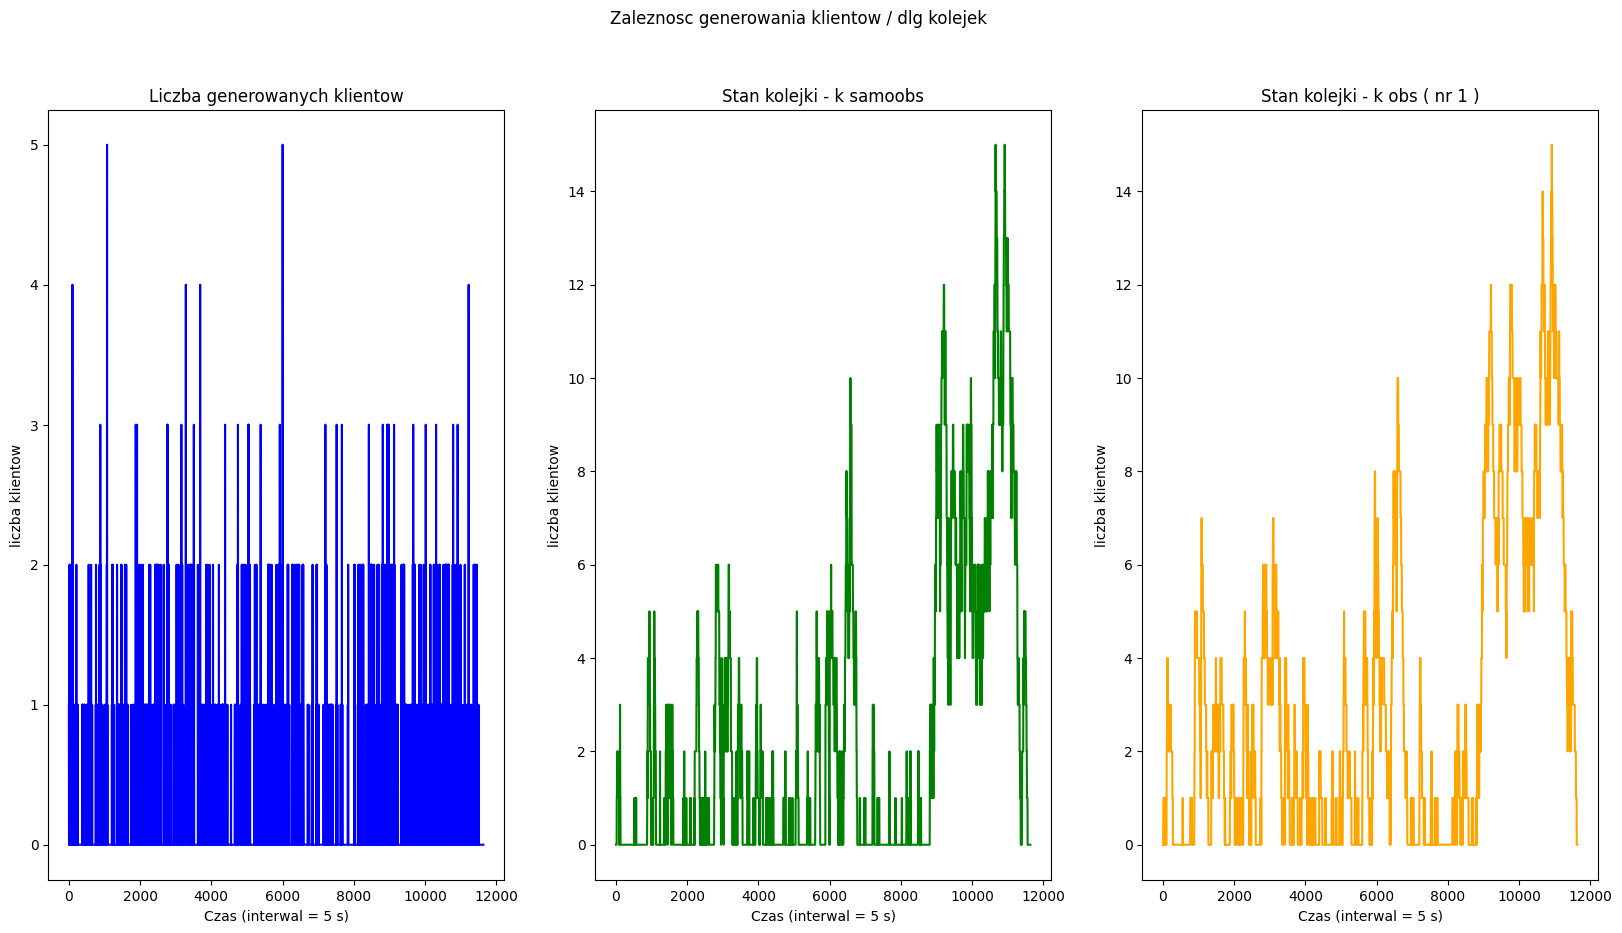



PROBA NR 2
Wszystkie info:
PARAMETRY:
	Czas symulacji: 57600
                            
	Liczba kas samoobslugowych: 3
                            
	Liczba kas obslugowych: 2
                            
	Lambda, amplituda, czestotliwosc: 0.081|0.765|1
-  --  --  --  --  --  --  --  --  --  -
WYNIKI: 
	Realny Czas symulacji: 58190
                          
	Liczba KL obsluzonych w roznych rodzajach (OBS \ SOBS): 714 \ 539
                          
	Sredni czas obslugi (OBS \ SOBS):  125.5168 \  240.3692
                          
	MAX kolejka (OBS \ SOBS): 14 \ 14
                          
	DELTA czas: 590
Najdlg Kolejka k_s: 14 w sekundzie: 7004
Klienci liczba: 1253


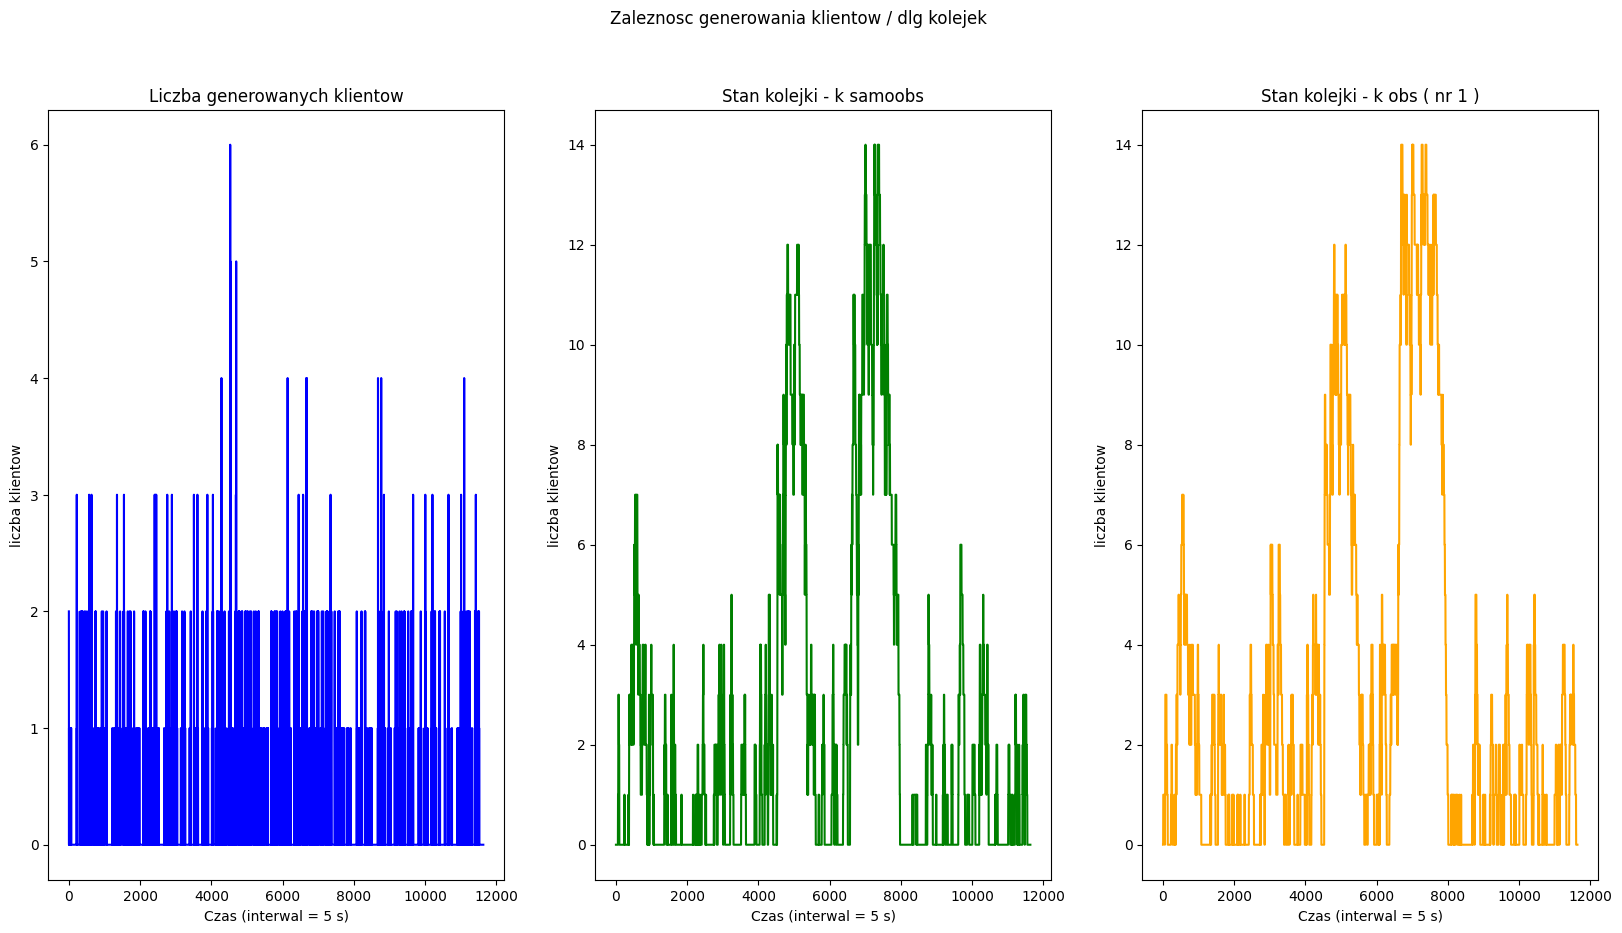



PROBA NR 3
Wszystkie info:
PARAMETRY:
	Czas symulacji: 57600
                            
	Liczba kas samoobslugowych: 3
                            
	Liczba kas obslugowych: 2
                            
	Lambda, amplituda, czestotliwosc: 0.081|0.765|1
-  --  --  --  --  --  --  --  --  --  -
WYNIKI: 
	Realny Czas symulacji: 57697
                          
	Liczba KL obsluzonych w roznych rodzajach (OBS \ SOBS): 713 \ 574
                          
	Sredni czas obslugi (OBS \ SOBS):  133.4530 \  236.0505
                          
	MAX kolejka (OBS \ SOBS): 11 \ 11
                          
	DELTA czas: 97
Najdlg Kolejka k_s: 11 w sekundzie: 1026
Klienci liczba: 1287


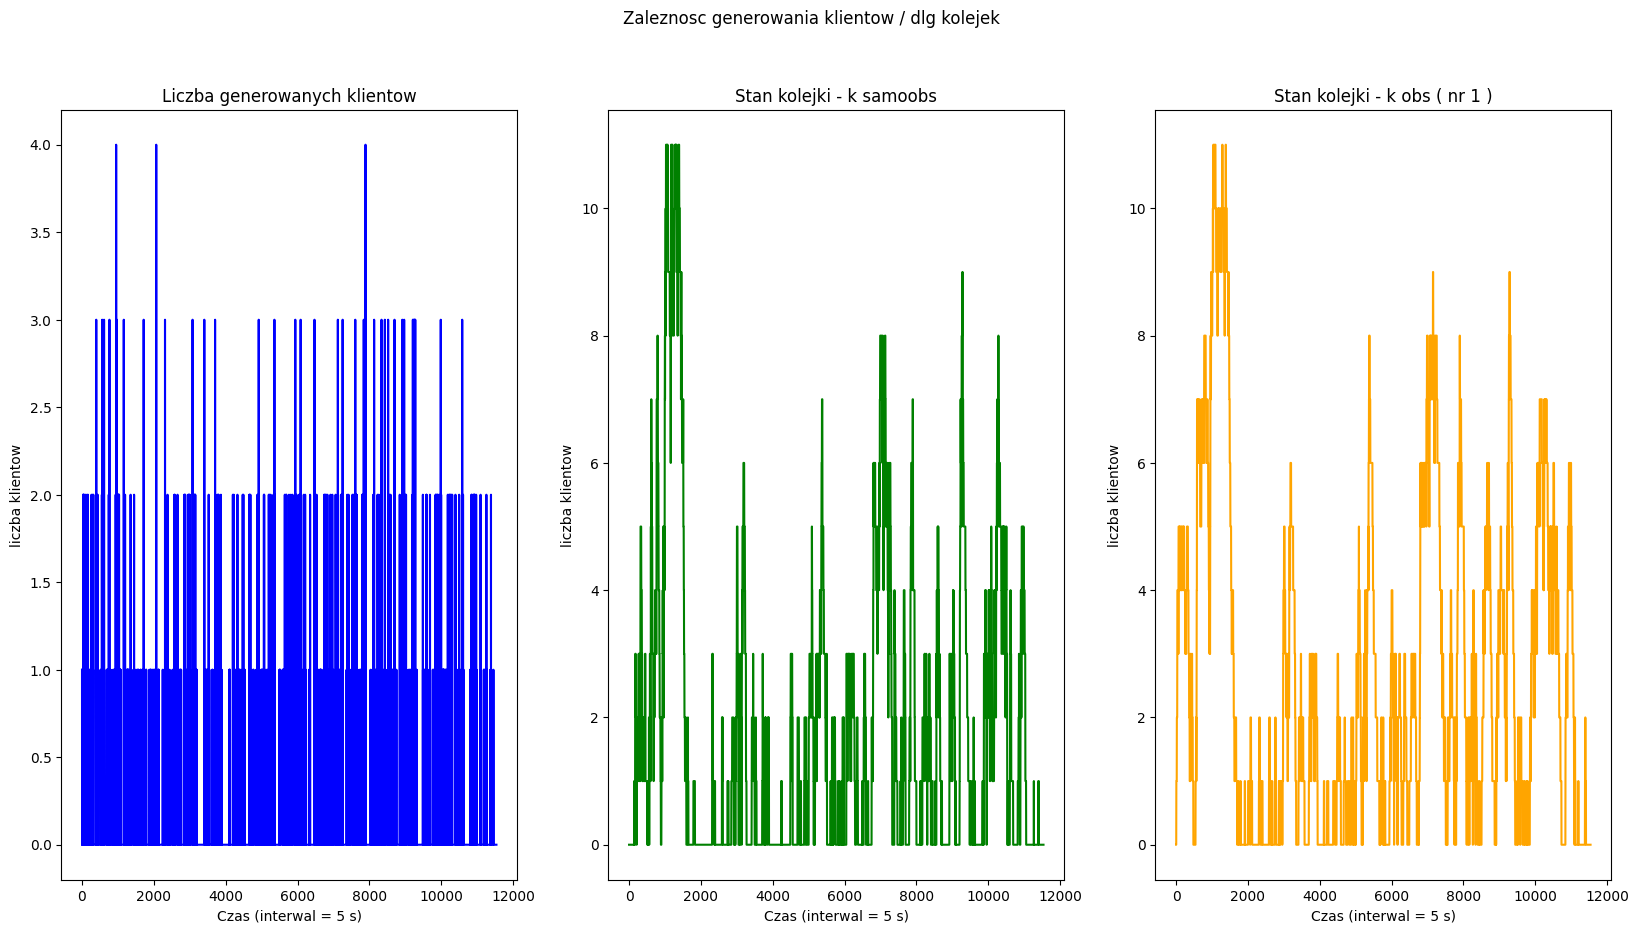



PROBA NR 1
Wszystkie info:
PARAMETRY:
	Czas symulacji: 57600
                            
	Liczba kas samoobslugowych: 3
                            
	Liczba kas obslugowych: 4
                            
	Lambda, amplituda, czestotliwosc: 0.081|0.765|1
-  --  --  --  --  --  --  --  --  --  -
WYNIKI: 
	Realny Czas symulacji: 57896
                          
	Liczba KL obsluzonych w roznych rodzajach (OBS \ SOBS): 734 \ 466
                          
	Sredni czas obslugi (OBS \ SOBS):  128.1144 \  234.1245
                          
	MAX kolejka (OBS \ SOBS): 3 \ 3
                          
	DELTA czas: 296
Najdlg Kolejka k_s: 3 w sekundzie: 162
Klienci liczba: 1200


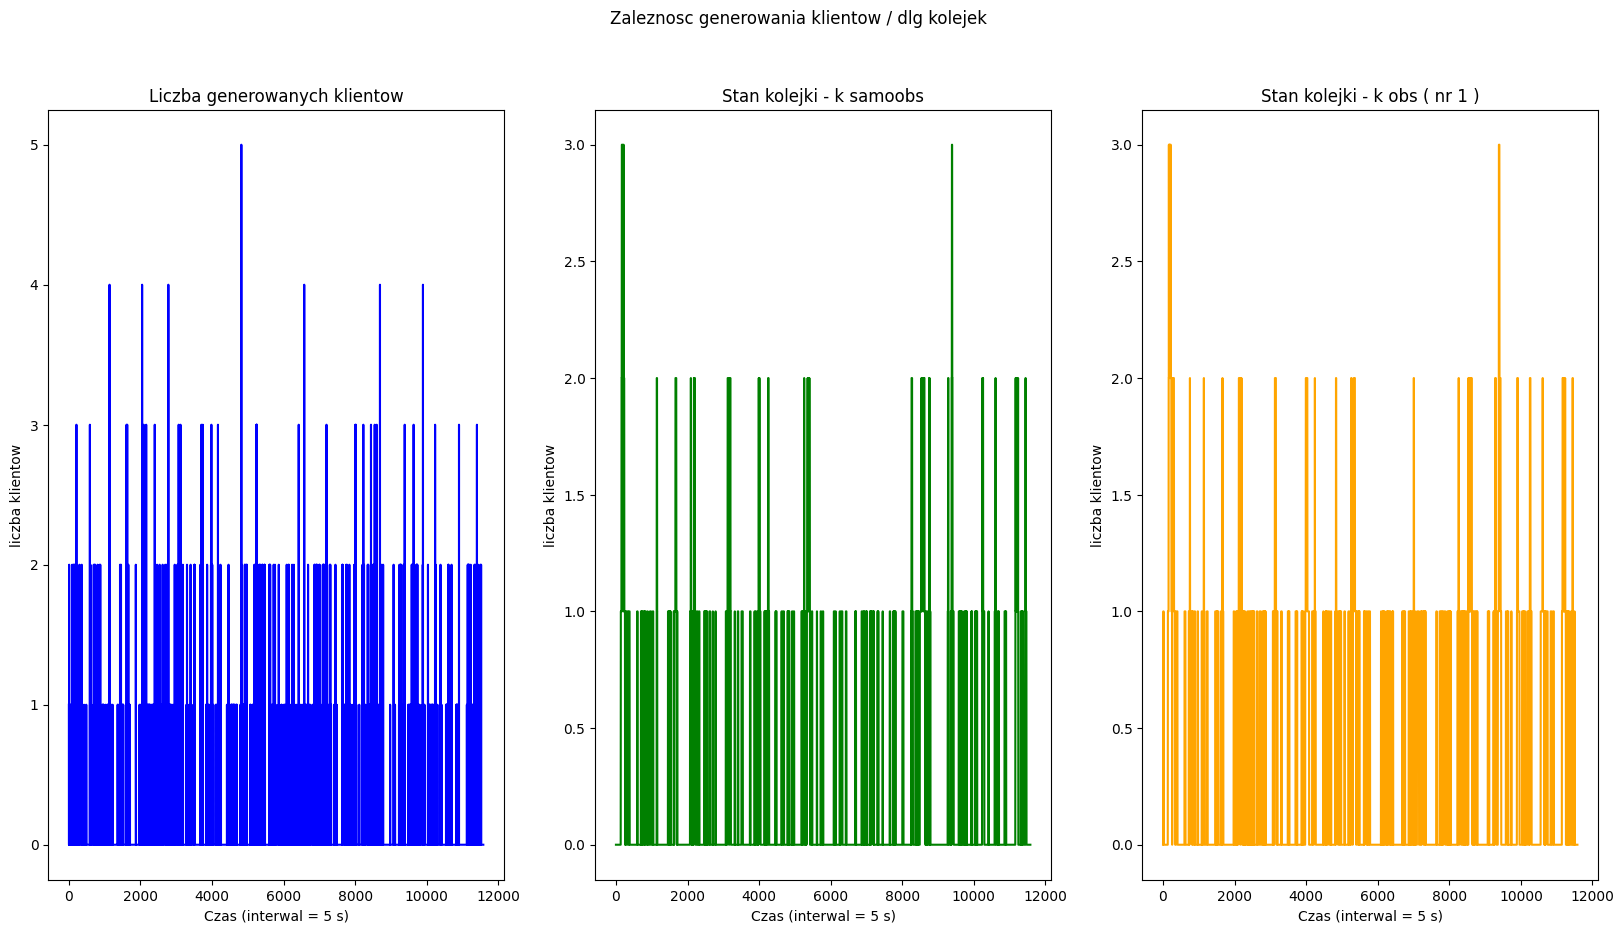



PROBA NR 2
Wszystkie info:
PARAMETRY:
	Czas symulacji: 57600
                            
	Liczba kas samoobslugowych: 3
                            
	Liczba kas obslugowych: 4
                            
	Lambda, amplituda, czestotliwosc: 0.081|0.765|1
-  --  --  --  --  --  --  --  --  --  -
WYNIKI: 
	Realny Czas symulacji: 57982
                          
	Liczba KL obsluzonych w roznych rodzajach (OBS \ SOBS): 828 \ 478
                          
	Sredni czas obslugi (OBS \ SOBS):  125.1159 \  237.3431
                          
	MAX kolejka (OBS \ SOBS): 5 \ 5
                          
	DELTA czas: 382
Najdlg Kolejka k_s: 5 w sekundzie: 4859
Klienci liczba: 1306


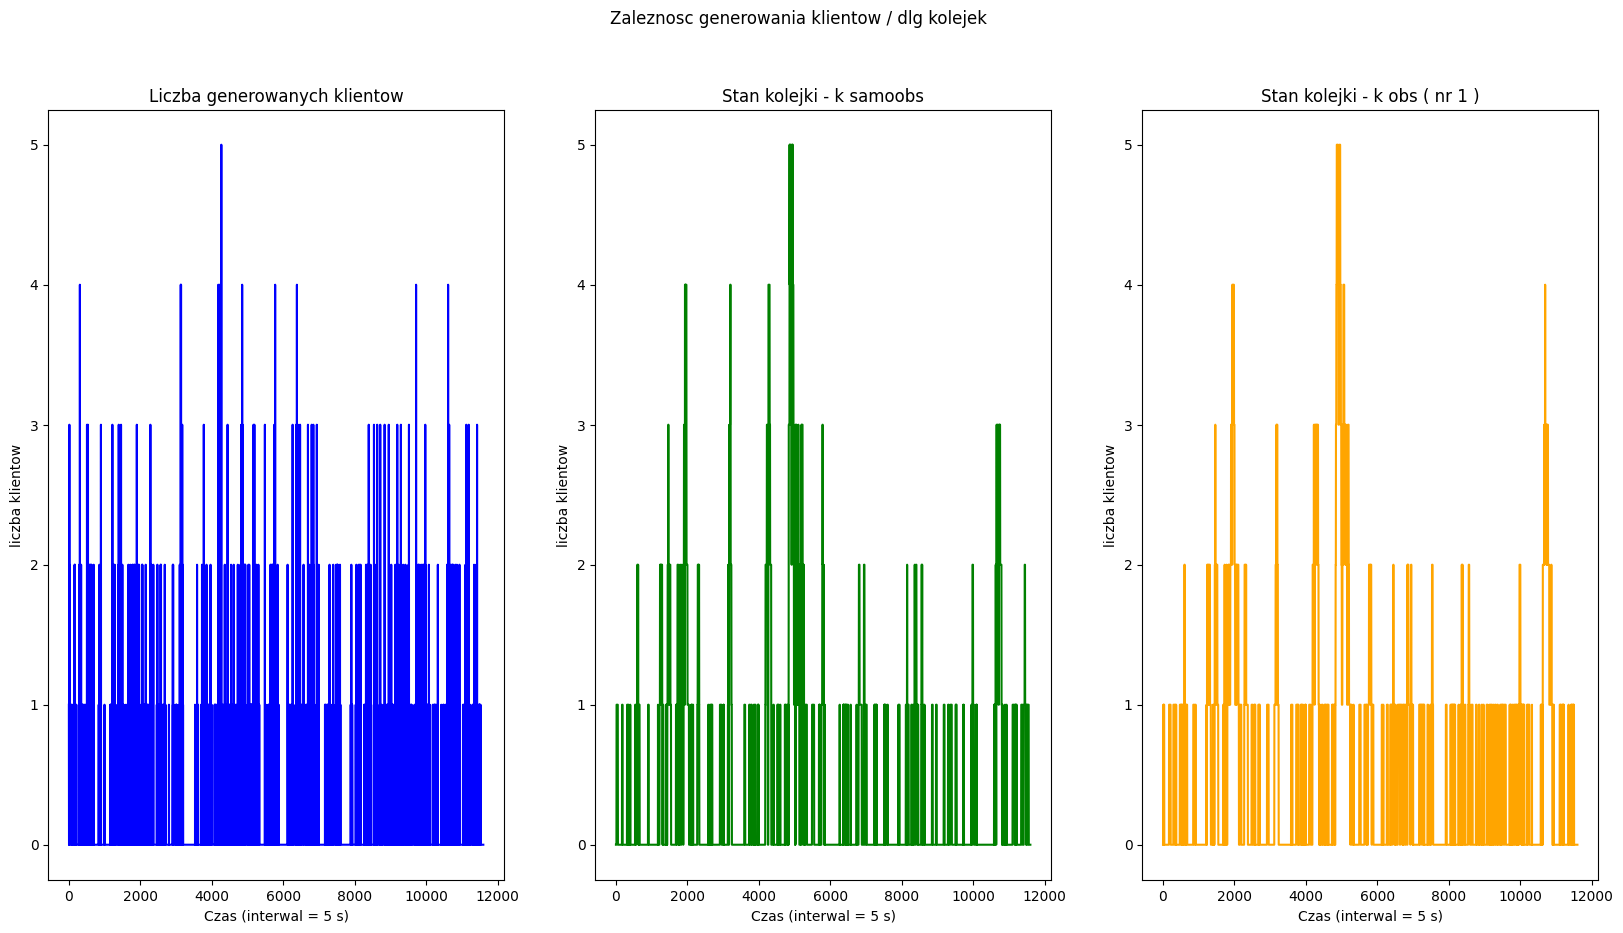



PROBA NR 3
Wszystkie info:
PARAMETRY:
	Czas symulacji: 57600
                            
	Liczba kas samoobslugowych: 3
                            
	Liczba kas obslugowych: 4
                            
	Lambda, amplituda, czestotliwosc: 0.081|0.765|1
-  --  --  --  --  --  --  --  --  --  -
WYNIKI: 
	Realny Czas symulacji: 57831
                          
	Liczba KL obsluzonych w roznych rodzajach (OBS \ SOBS): 791 \ 470
                          
	Sredni czas obslugi (OBS \ SOBS):  125.2200 \  239.0596
                          
	MAX kolejka (OBS \ SOBS): 3 \ 3
                          
	DELTA czas: 231
Najdlg Kolejka k_s: 3 w sekundzie: 2183
Klienci liczba: 1261


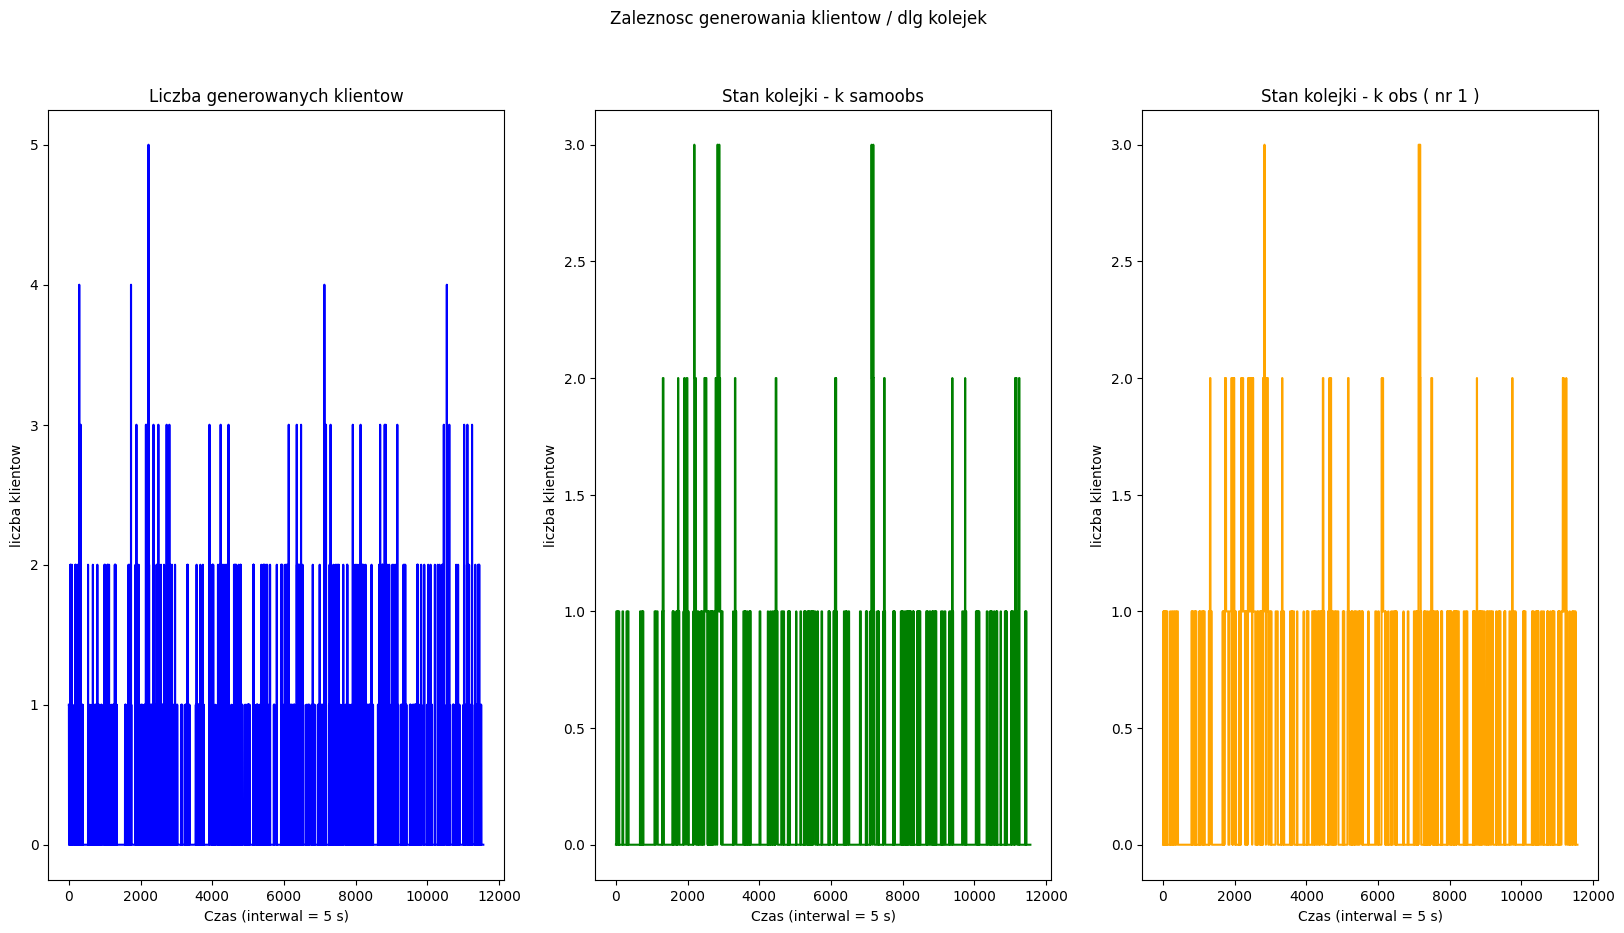



PROBA NR 1
Wszystkie info:
PARAMETRY:
	Czas symulacji: 57600
                            
	Liczba kas samoobslugowych: 8
                            
	Liczba kas obslugowych: 2
                            
	Lambda, amplituda, czestotliwosc: 0.081|0.765|1
-  --  --  --  --  --  --  --  --  --  -
WYNIKI: 
	Realny Czas symulacji: 57972
                          
	Liczba KL obsluzonych w roznych rodzajach (OBS \ SOBS): 576 \ 808
                          
	Sredni czas obslugi (OBS \ SOBS):  126.9653 \  234.8131
                          
	MAX kolejka (OBS \ SOBS): 7 \ 6
                          
	DELTA czas: 372
Najdlg Kolejka k_s: 6 w sekundzie: 7547
Klienci liczba: 1384


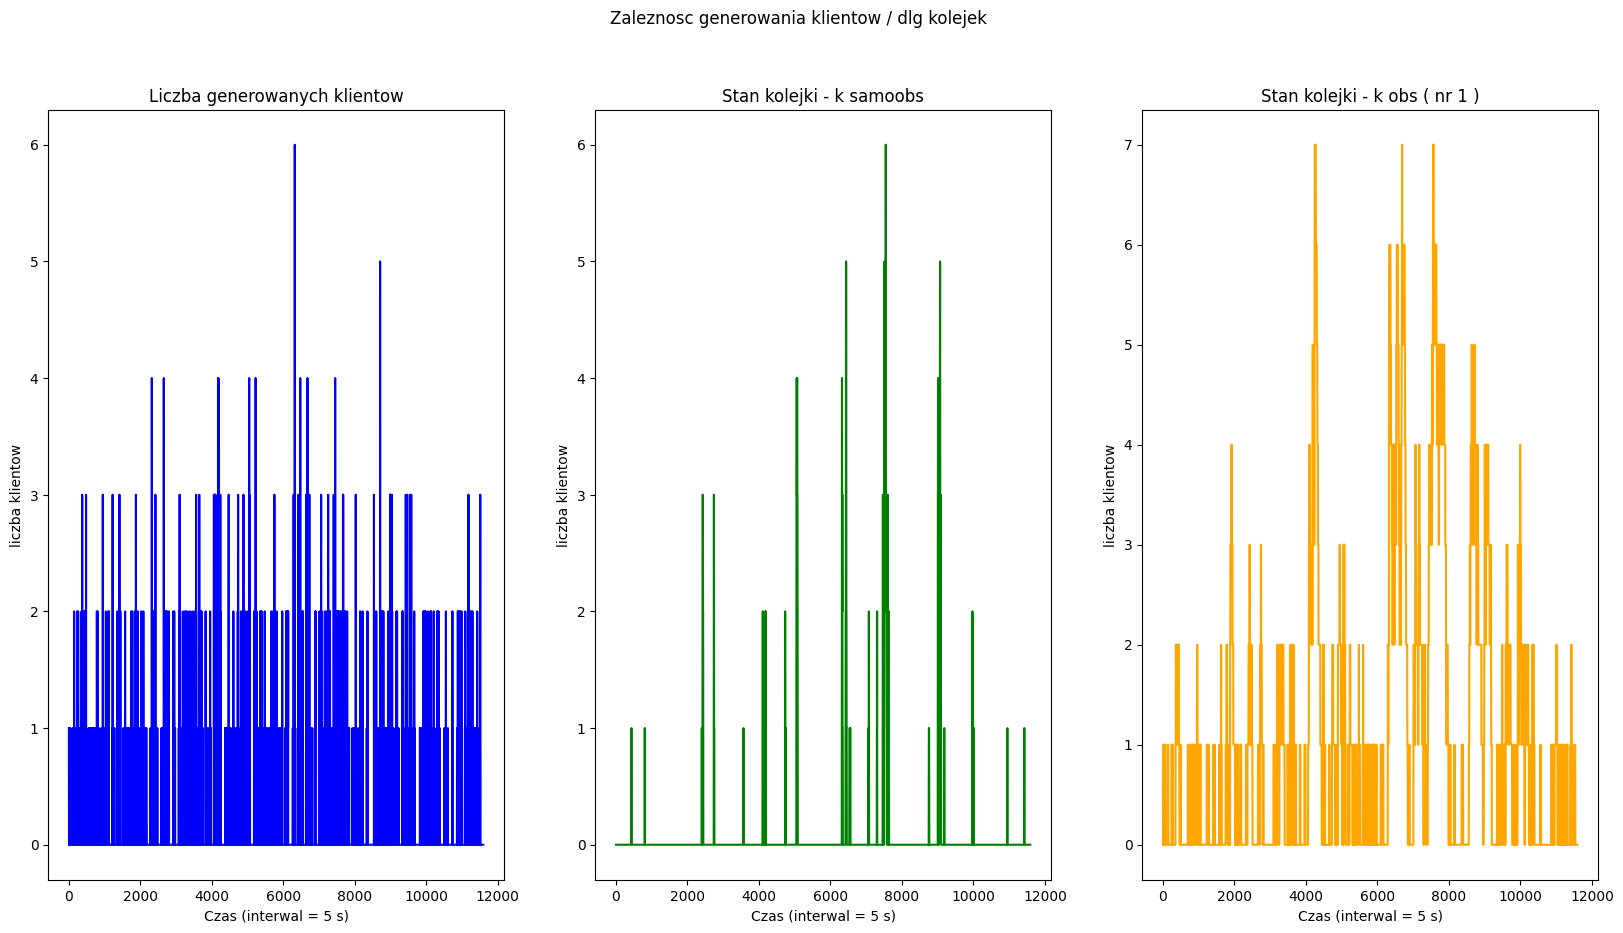



PROBA NR 2
Wszystkie info:
PARAMETRY:
	Czas symulacji: 57600
                            
	Liczba kas samoobslugowych: 8
                            
	Liczba kas obslugowych: 2
                            
	Lambda, amplituda, czestotliwosc: 0.081|0.765|1
-  --  --  --  --  --  --  --  --  --  -
WYNIKI: 
	Realny Czas symulacji: 57904
                          
	Liczba KL obsluzonych w roznych rodzajach (OBS \ SOBS): 490 \ 677
                          
	Sredni czas obslugi (OBS \ SOBS):  129.4571 \  241.0798
                          
	MAX kolejka (OBS \ SOBS): 6 \ 6
                          
	DELTA czas: 304
Najdlg Kolejka k_s: 6 w sekundzie: 2565
Klienci liczba: 1167


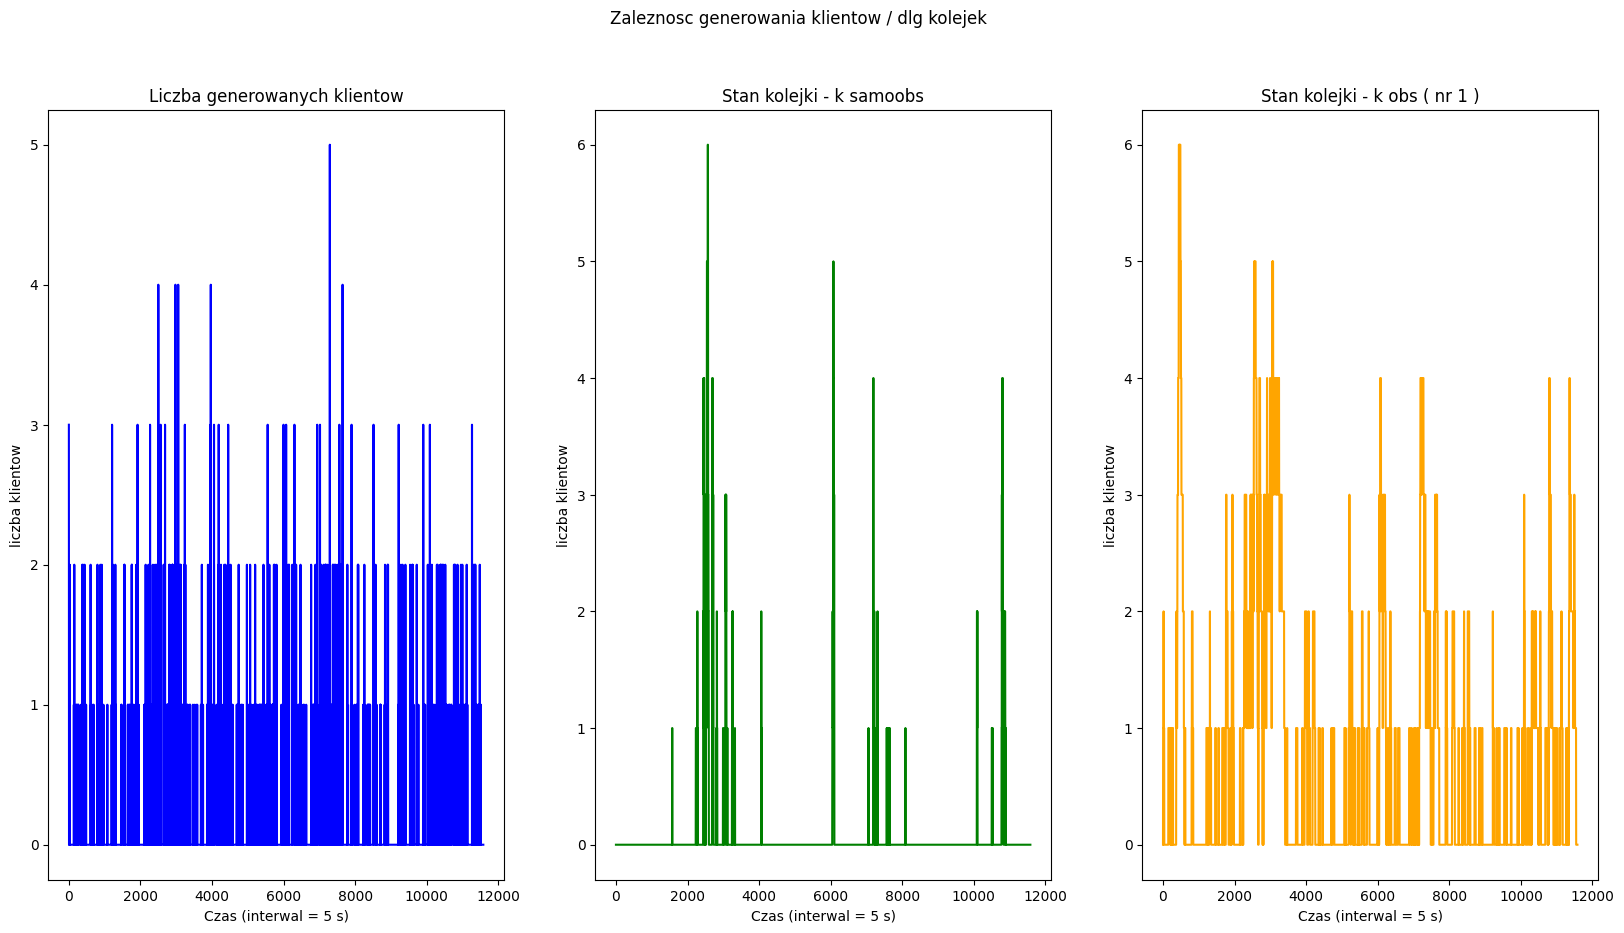



PROBA NR 3
Wszystkie info:
PARAMETRY:
	Czas symulacji: 57600
                            
	Liczba kas samoobslugowych: 8
                            
	Liczba kas obslugowych: 2
                            
	Lambda, amplituda, czestotliwosc: 0.081|0.765|1
-  --  --  --  --  --  --  --  --  --  -
WYNIKI: 
	Realny Czas symulacji: 57859
                          
	Liczba KL obsluzonych w roznych rodzajach (OBS \ SOBS): 508 \ 730
                          
	Sredni czas obslugi (OBS \ SOBS):  128.0846 \  241.2548
                          
	MAX kolejka (OBS \ SOBS): 7 \ 6
                          
	DELTA czas: 259
Najdlg Kolejka k_s: 6 w sekundzie: 8326
Klienci liczba: 1238


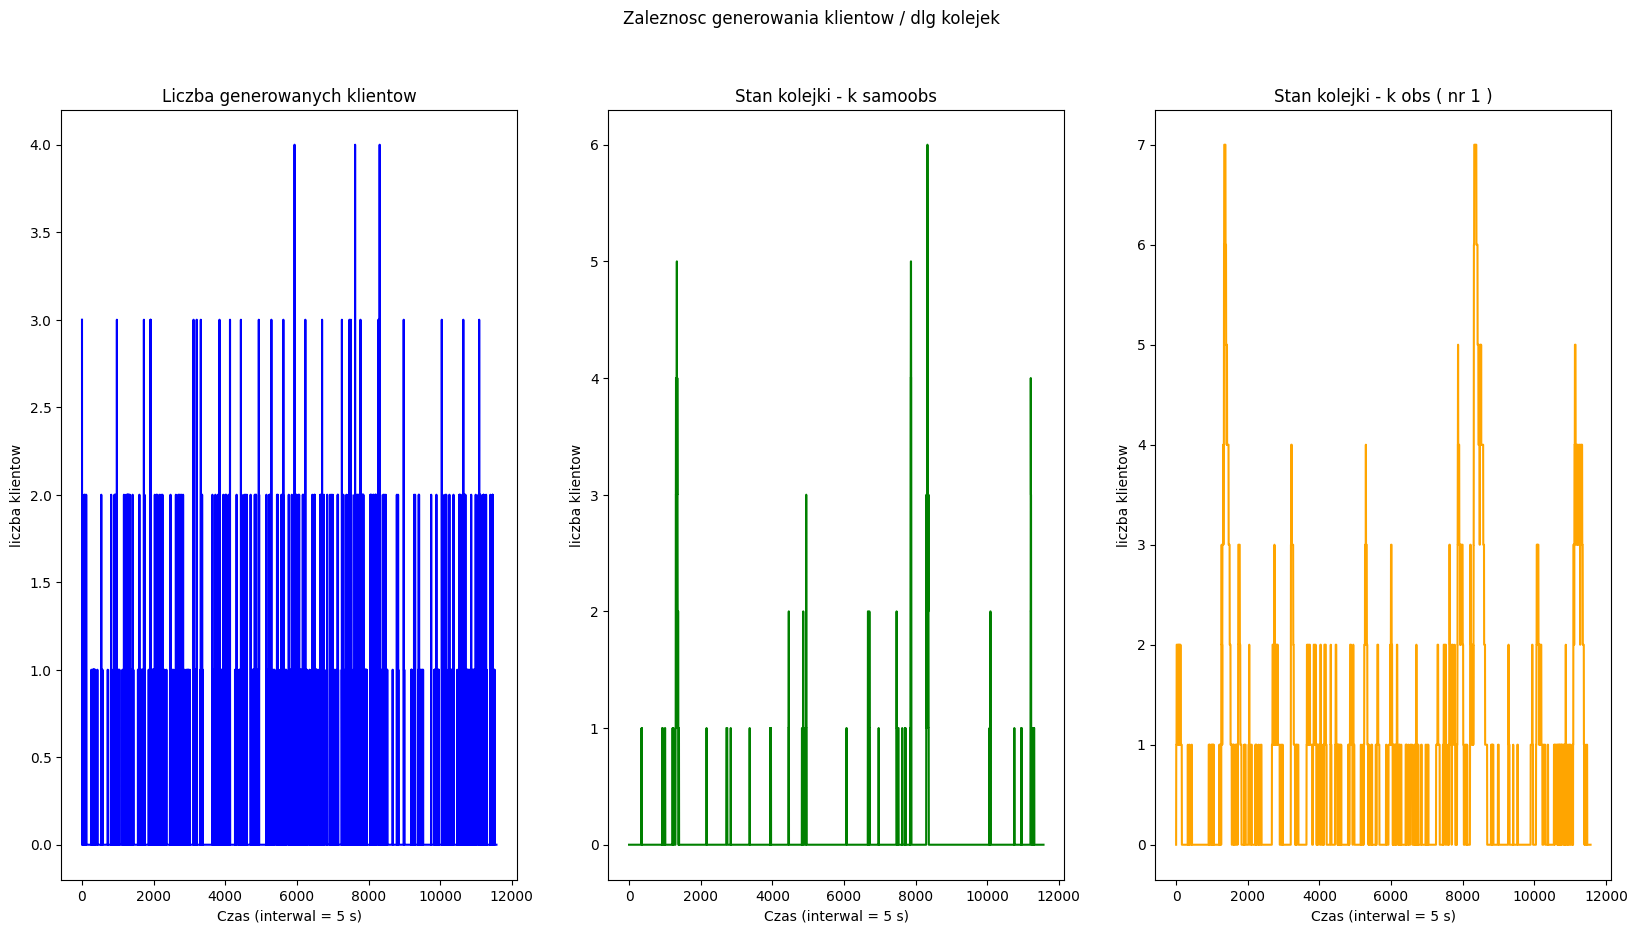



PROBA NR 1
Wszystkie info:
PARAMETRY:
	Czas symulacji: 57600
                            
	Liczba kas samoobslugowych: 8
                            
	Liczba kas obslugowych: 4
                            
	Lambda, amplituda, czestotliwosc: 0.081|0.765|1
-  --  --  --  --  --  --  --  --  --  -
WYNIKI: 
	Realny Czas symulacji: 57914
                          
	Liczba KL obsluzonych w roznych rodzajach (OBS \ SOBS): 549 \ 703
                          
	Sredni czas obslugi (OBS \ SOBS):  130.3534 \  234.5576
                          
	MAX kolejka (OBS \ SOBS): 3 \ 2
                          
	DELTA czas: 314
Najdlg Kolejka k_s: 2 w sekundzie: 2109
Klienci liczba: 1252


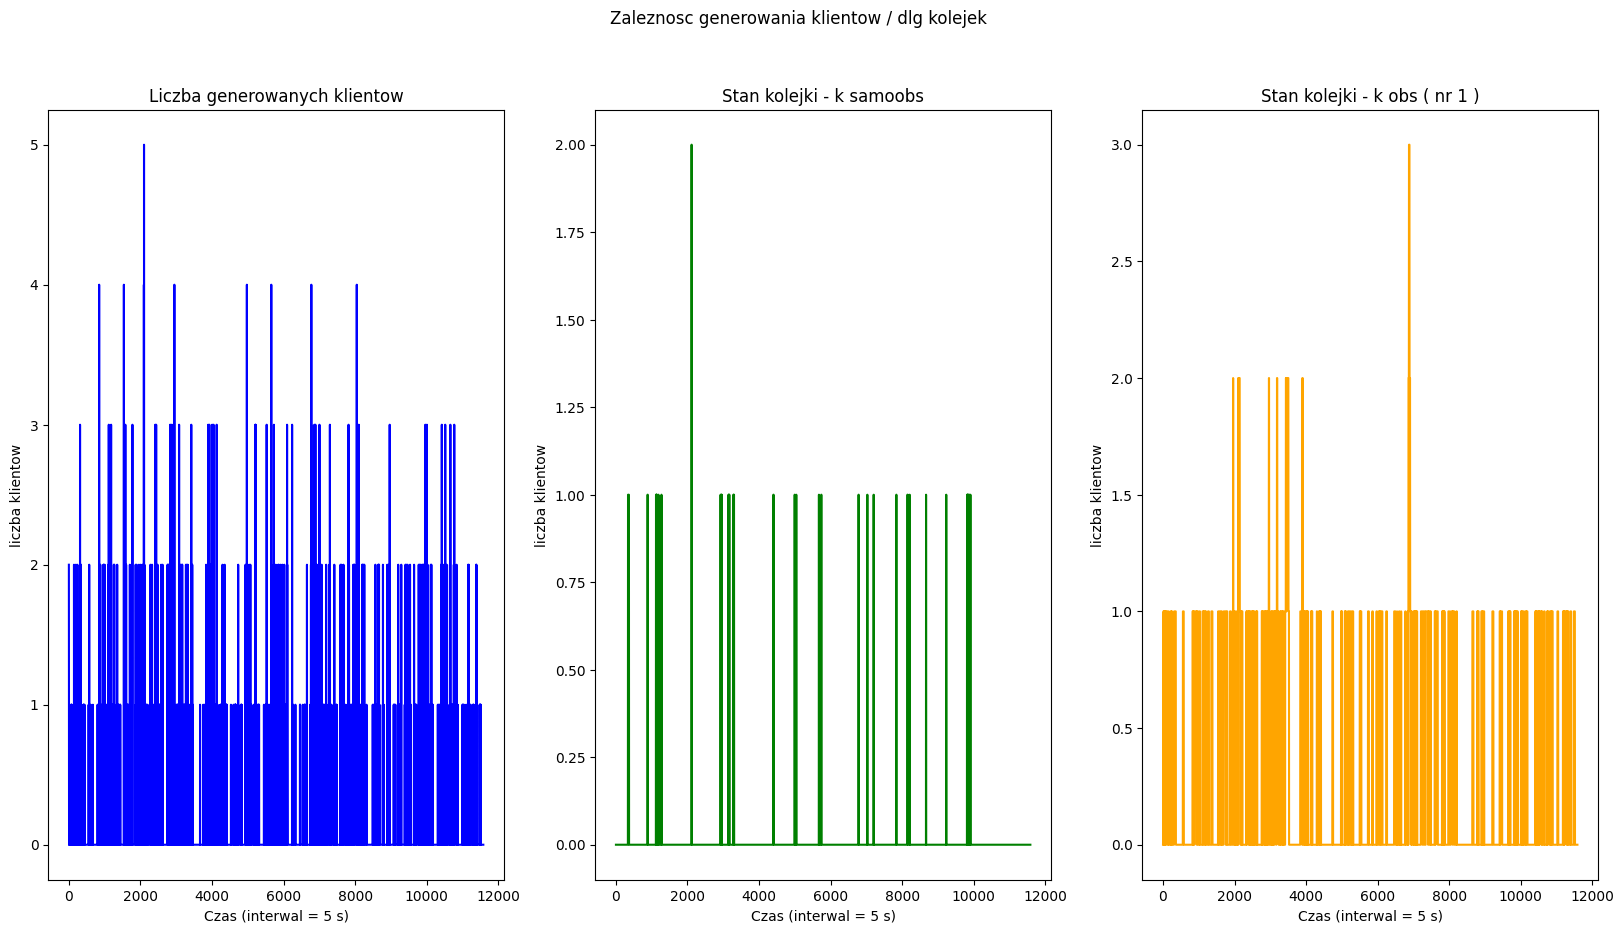



PROBA NR 2
Wszystkie info:
PARAMETRY:
	Czas symulacji: 57600
                            
	Liczba kas samoobslugowych: 8
                            
	Liczba kas obslugowych: 4
                            
	Lambda, amplituda, czestotliwosc: 0.081|0.765|1
-  --  --  --  --  --  --  --  --  --  -
WYNIKI: 
	Realny Czas symulacji: 58064
                          
	Liczba KL obsluzonych w roznych rodzajach (OBS \ SOBS): 582 \ 779
                          
	Sredni czas obslugi (OBS \ SOBS):  129.9536 \  255.7445
                          
	MAX kolejka (OBS \ SOBS): 2 \ 2
                          
	DELTA czas: 464
Najdlg Kolejka k_s: 2 w sekundzie: 1887
Klienci liczba: 1361


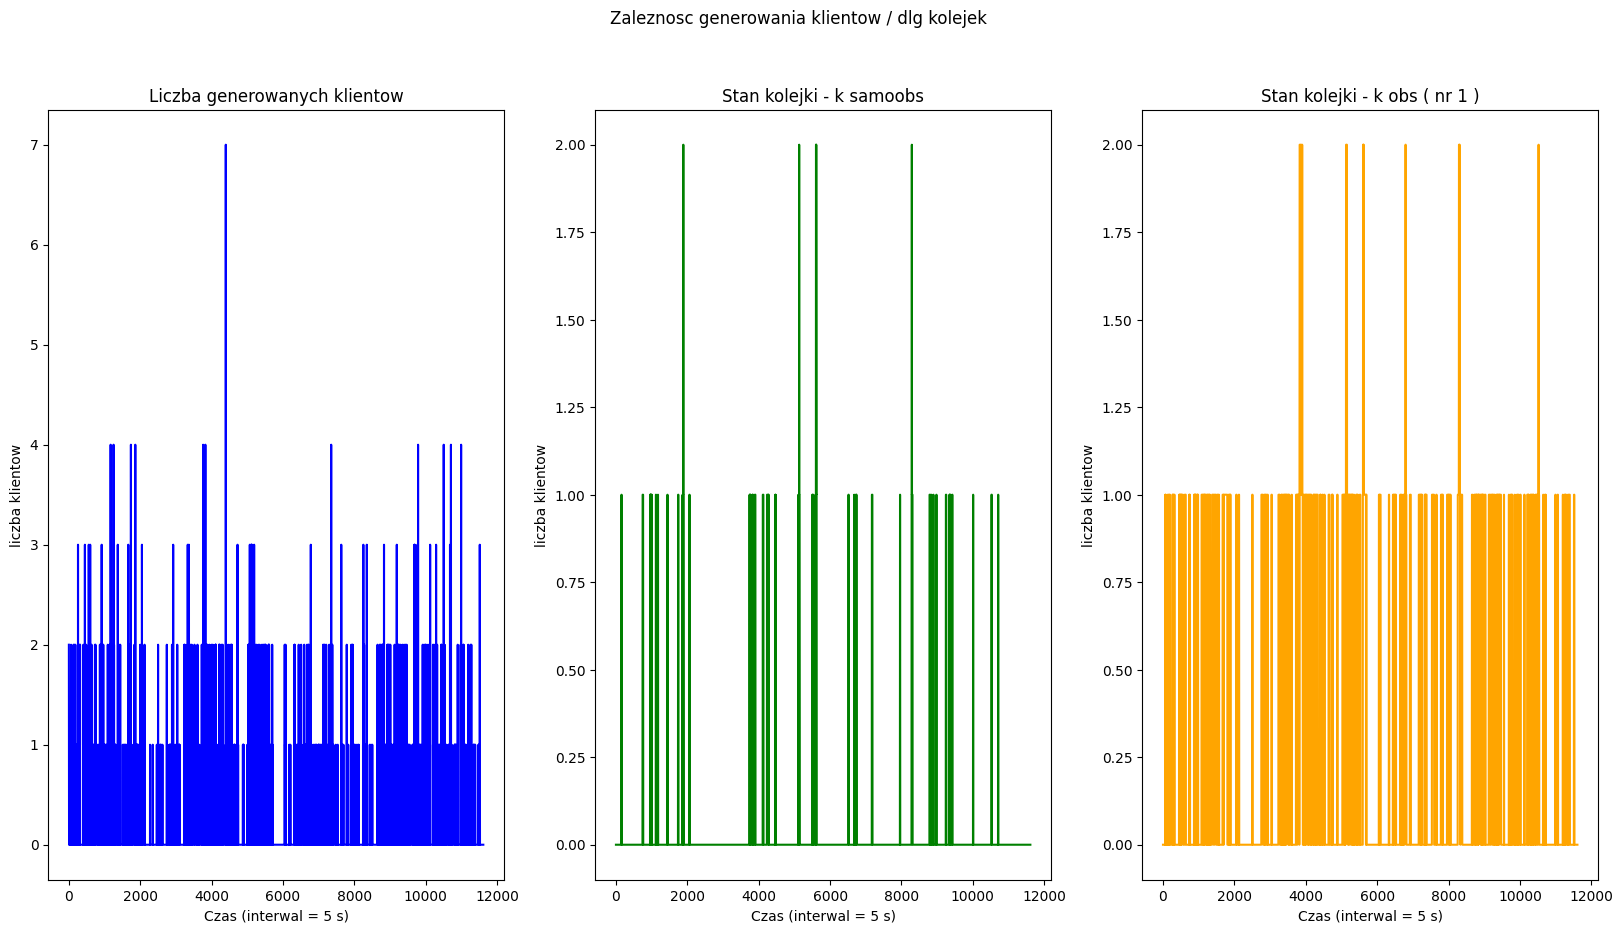



PROBA NR 3
Wszystkie info:
PARAMETRY:
	Czas symulacji: 57600
                            
	Liczba kas samoobslugowych: 8
                            
	Liczba kas obslugowych: 4
                            
	Lambda, amplituda, czestotliwosc: 0.081|0.765|1
-  --  --  --  --  --  --  --  --  --  -
WYNIKI: 
	Realny Czas symulacji: 57911
                          
	Liczba KL obsluzonych w roznych rodzajach (OBS \ SOBS): 585 \ 734
                          
	Sredni czas obslugi (OBS \ SOBS):  131.7590 \  246.6104
                          
	MAX kolejka (OBS \ SOBS): 3 \ 3
                          
	DELTA czas: 311
Najdlg Kolejka k_s: 3 w sekundzie: 5935
Klienci liczba: 1319


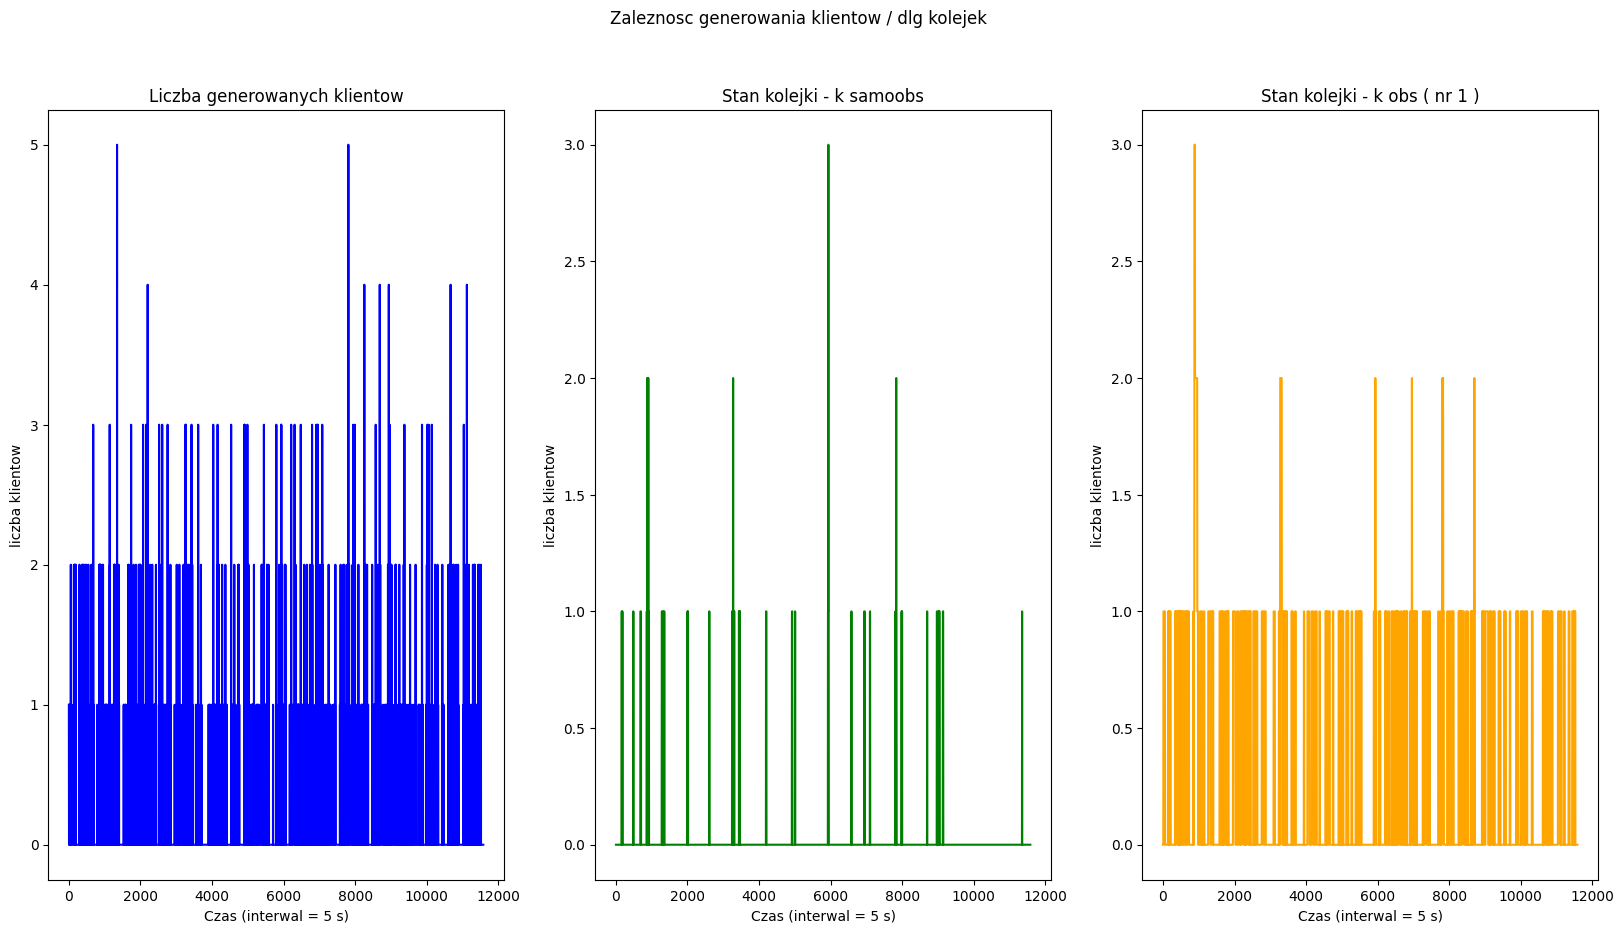



PROBA NR 1
Wszystkie info:
PARAMETRY:
	Czas symulacji: 57600
                            
	Liczba kas samoobslugowych: 3
                            
	Liczba kas obslugowych: 2
                            
	Lambda, amplituda, czestotliwosc: 0.158|0.765|1
-  --  --  --  --  --  --  --  --  --  -
WYNIKI: 
	Realny Czas symulacji: 97845
                          
	Liczba KL obsluzonych w roznych rodzajach (OBS \ SOBS): 1570 \ 1041
                          
	Sredni czas obslugi (OBS \ SOBS):  122.8930 \  239.9606
                          
	MAX kolejka (OBS \ SOBS): 317 \ 317
                          
	DELTA czas: 40245
Najdlg Kolejka k_s: 317 w sekundzie: 11508
Klienci liczba: 2611


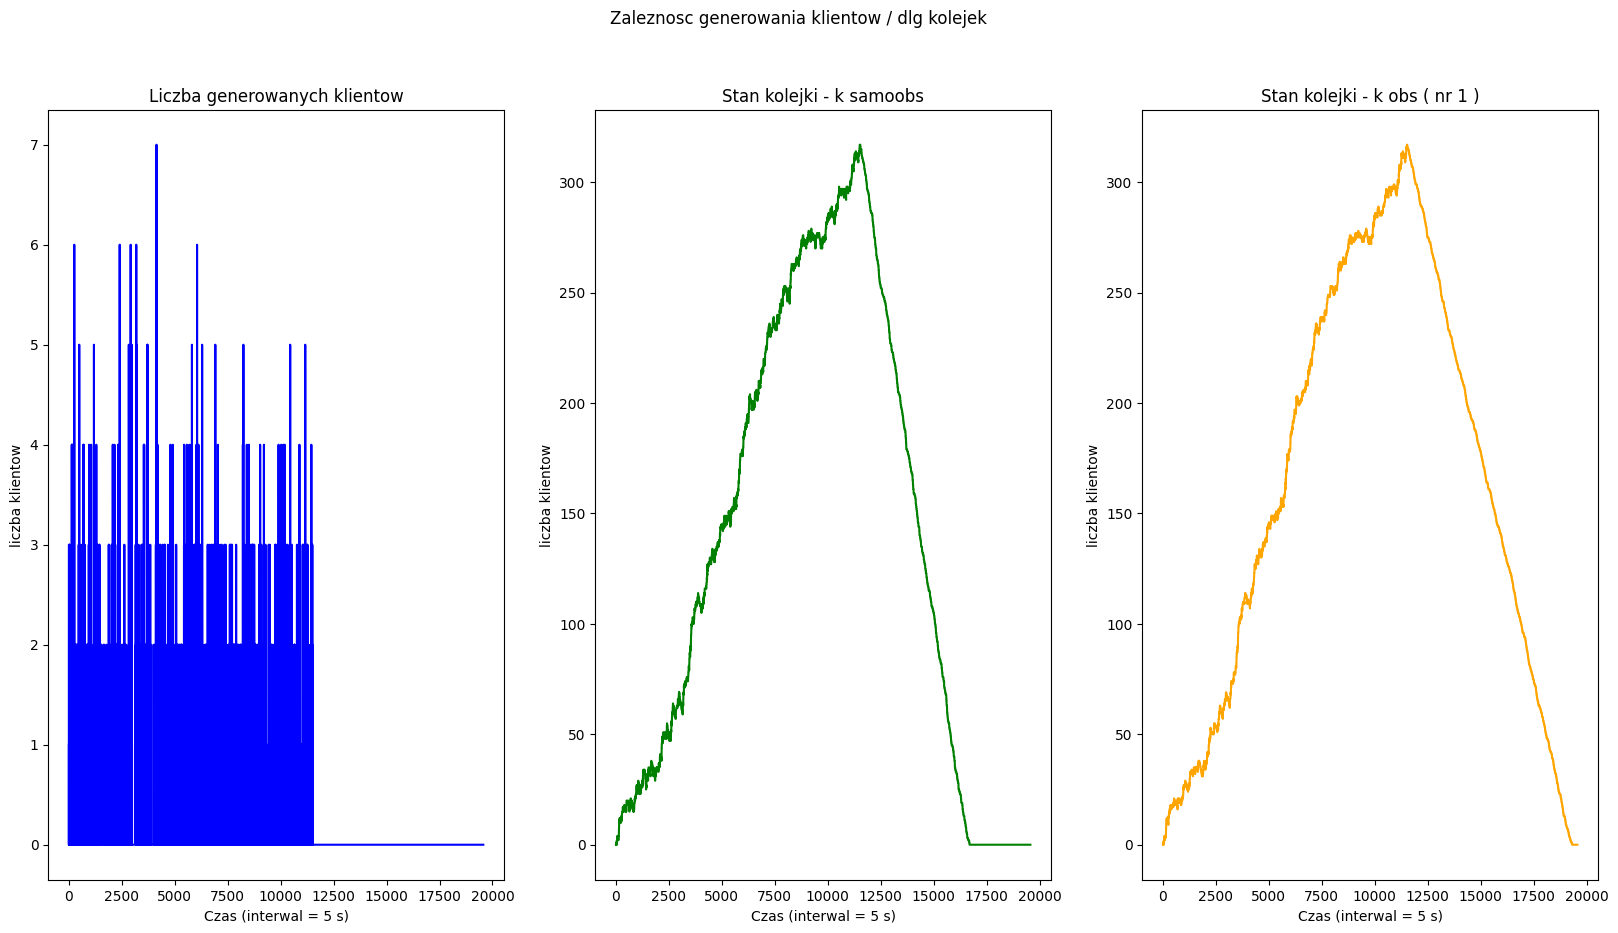



PROBA NR 2
Wszystkie info:
PARAMETRY:
	Czas symulacji: 57600
                            
	Liczba kas samoobslugowych: 3
                            
	Liczba kas obslugowych: 2
                            
	Lambda, amplituda, czestotliwosc: 0.158|0.765|1
-  --  --  --  --  --  --  --  --  --  -
WYNIKI: 
	Realny Czas symulacji: 93645
                          
	Liczba KL obsluzonych w roznych rodzajach (OBS \ SOBS): 1417 \ 997
                          
	Sredni czas obslugi (OBS \ SOBS):  130.7953 \  239.1876
                          
	MAX kolejka (OBS \ SOBS): 273 \ 271
                          
	DELTA czas: 36045
Najdlg Kolejka k_s: 271 w sekundzie: 11394
Klienci liczba: 2414


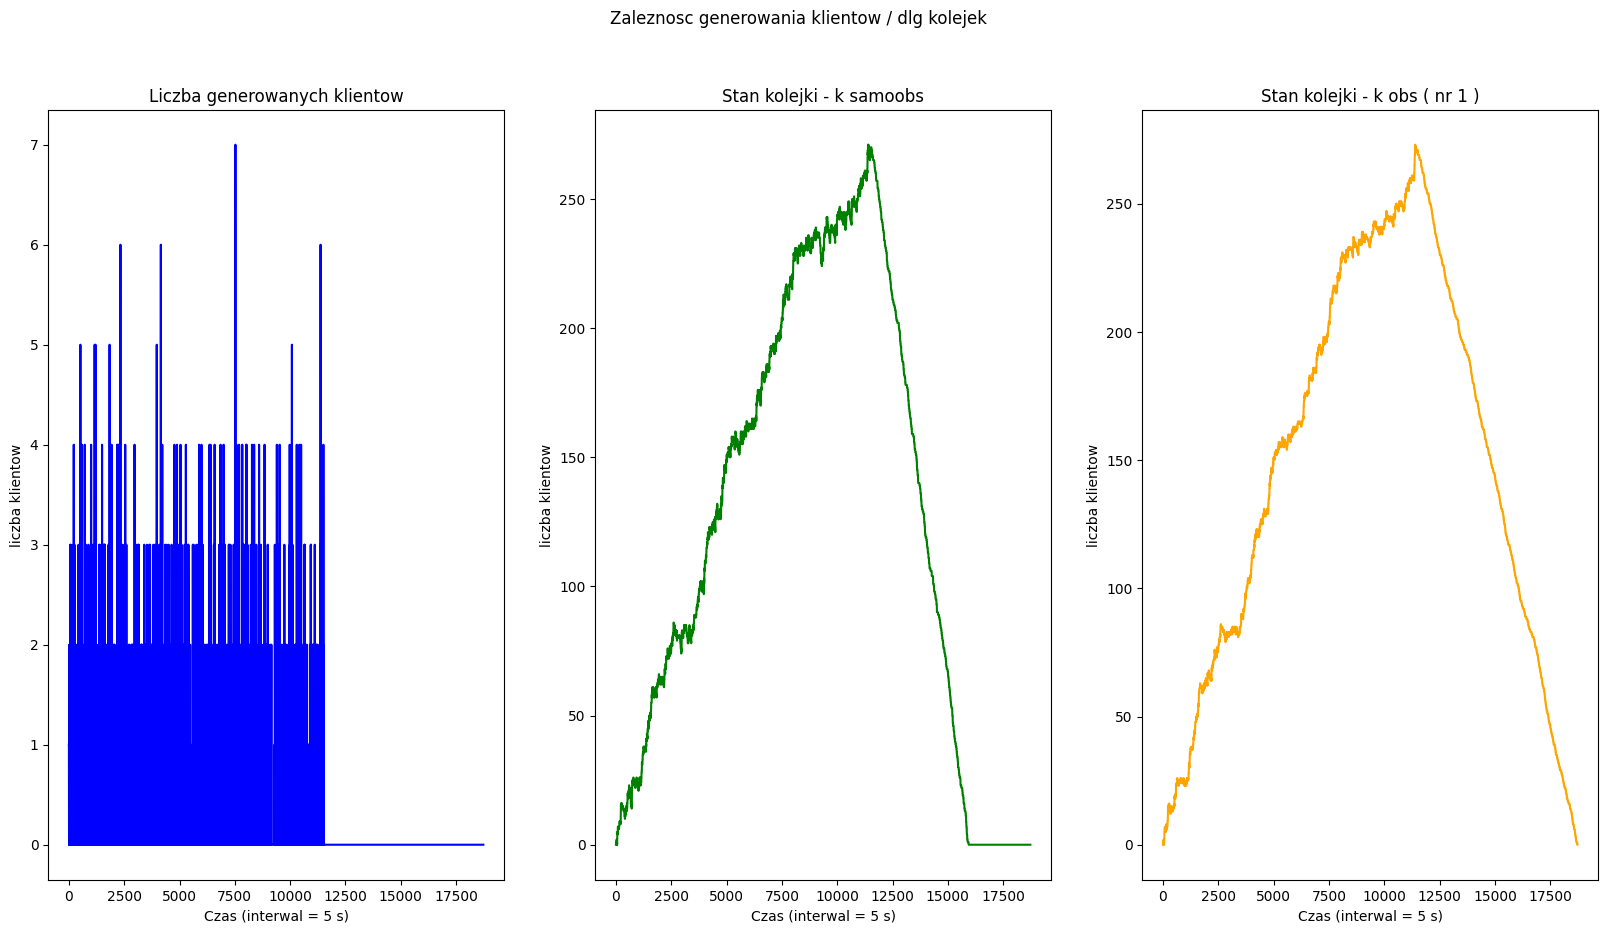



PROBA NR 3
Wszystkie info:
PARAMETRY:
	Czas symulacji: 57600
                            
	Liczba kas samoobslugowych: 3
                            
	Liczba kas obslugowych: 2
                            
	Lambda, amplituda, czestotliwosc: 0.158|0.765|1
-  --  --  --  --  --  --  --  --  --  -
WYNIKI: 
	Realny Czas symulacji: 94962
                          
	Liczba KL obsluzonych w roznych rodzajach (OBS \ SOBS): 1428 \ 991
                          
	Sredni czas obslugi (OBS \ SOBS):  129.4006 \  238.5419
                          
	MAX kolejka (OBS \ SOBS): 277 \ 278
                          
	DELTA czas: 37362
Najdlg Kolejka k_s: 278 w sekundzie: 11400
Klienci liczba: 2419


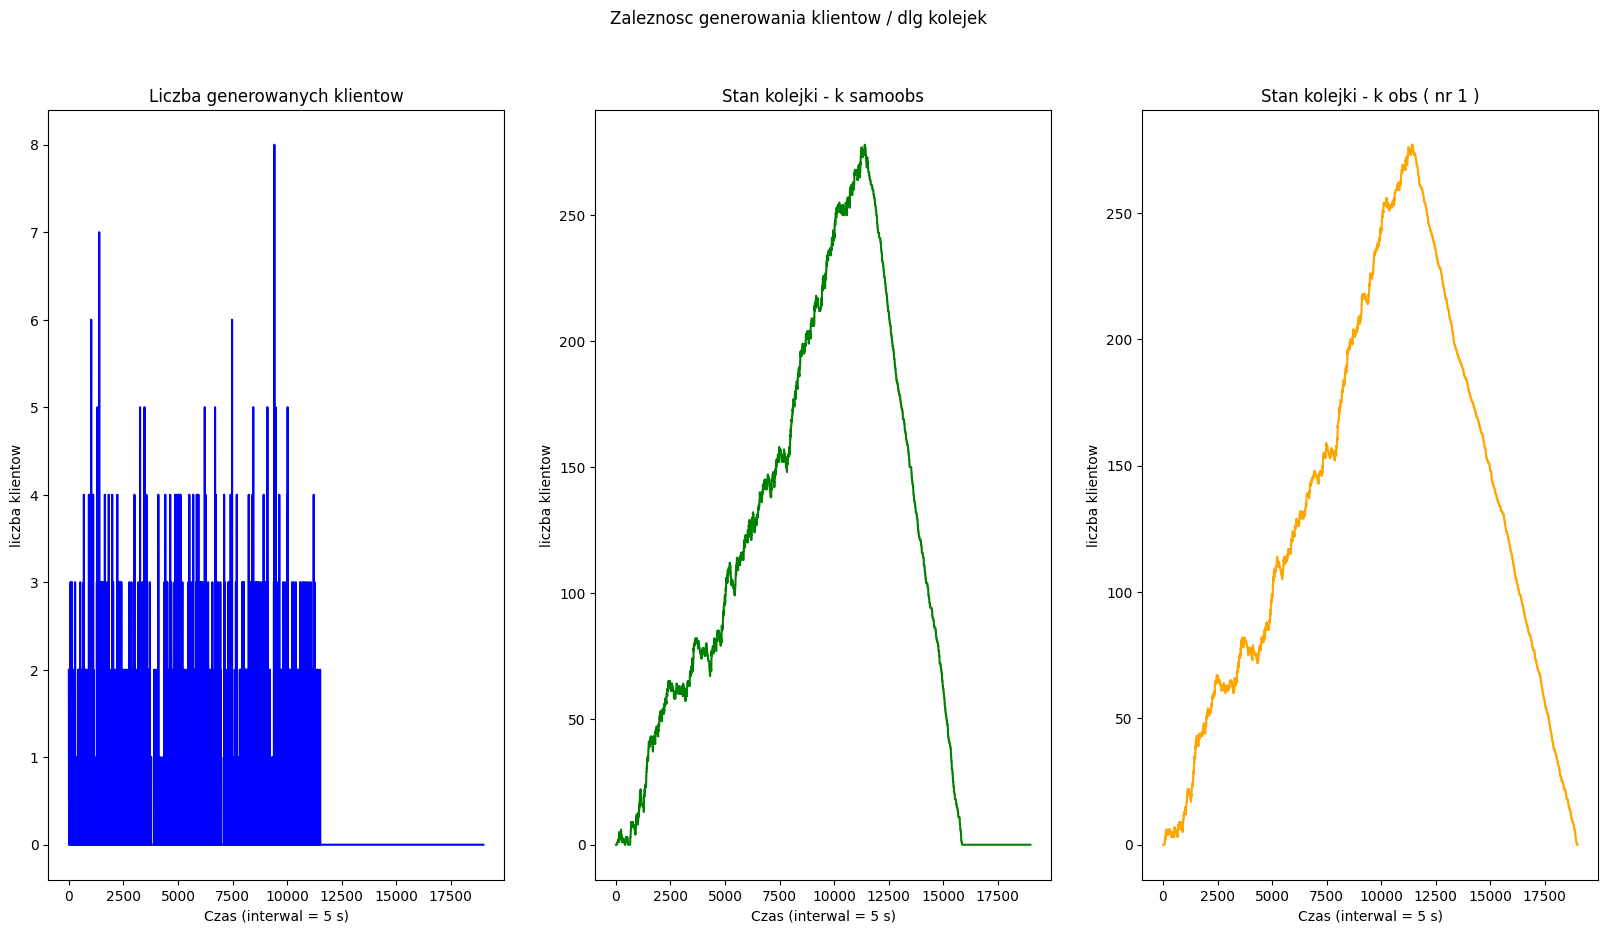



PROBA NR 1
Wszystkie info:
PARAMETRY:
	Czas symulacji: 57600
                            
	Liczba kas samoobslugowych: 3
                            
	Liczba kas obslugowych: 4
                            
	Lambda, amplituda, czestotliwosc: 0.158|0.765|1
-  --  --  --  --  --  --  --  --  --  -
WYNIKI: 
	Realny Czas symulacji: 60252
                          
	Liczba KL obsluzonych w roznych rodzajach (OBS \ SOBS): 1842 \ 699
                          
	Sredni czas obslugi (OBS \ SOBS):  123.6156 \  244.9456
                          
	MAX kolejka (OBS \ SOBS): 26 \ 26
                          
	DELTA czas: 2652
Najdlg Kolejka k_s: 26 w sekundzie: 10396
Klienci liczba: 2541


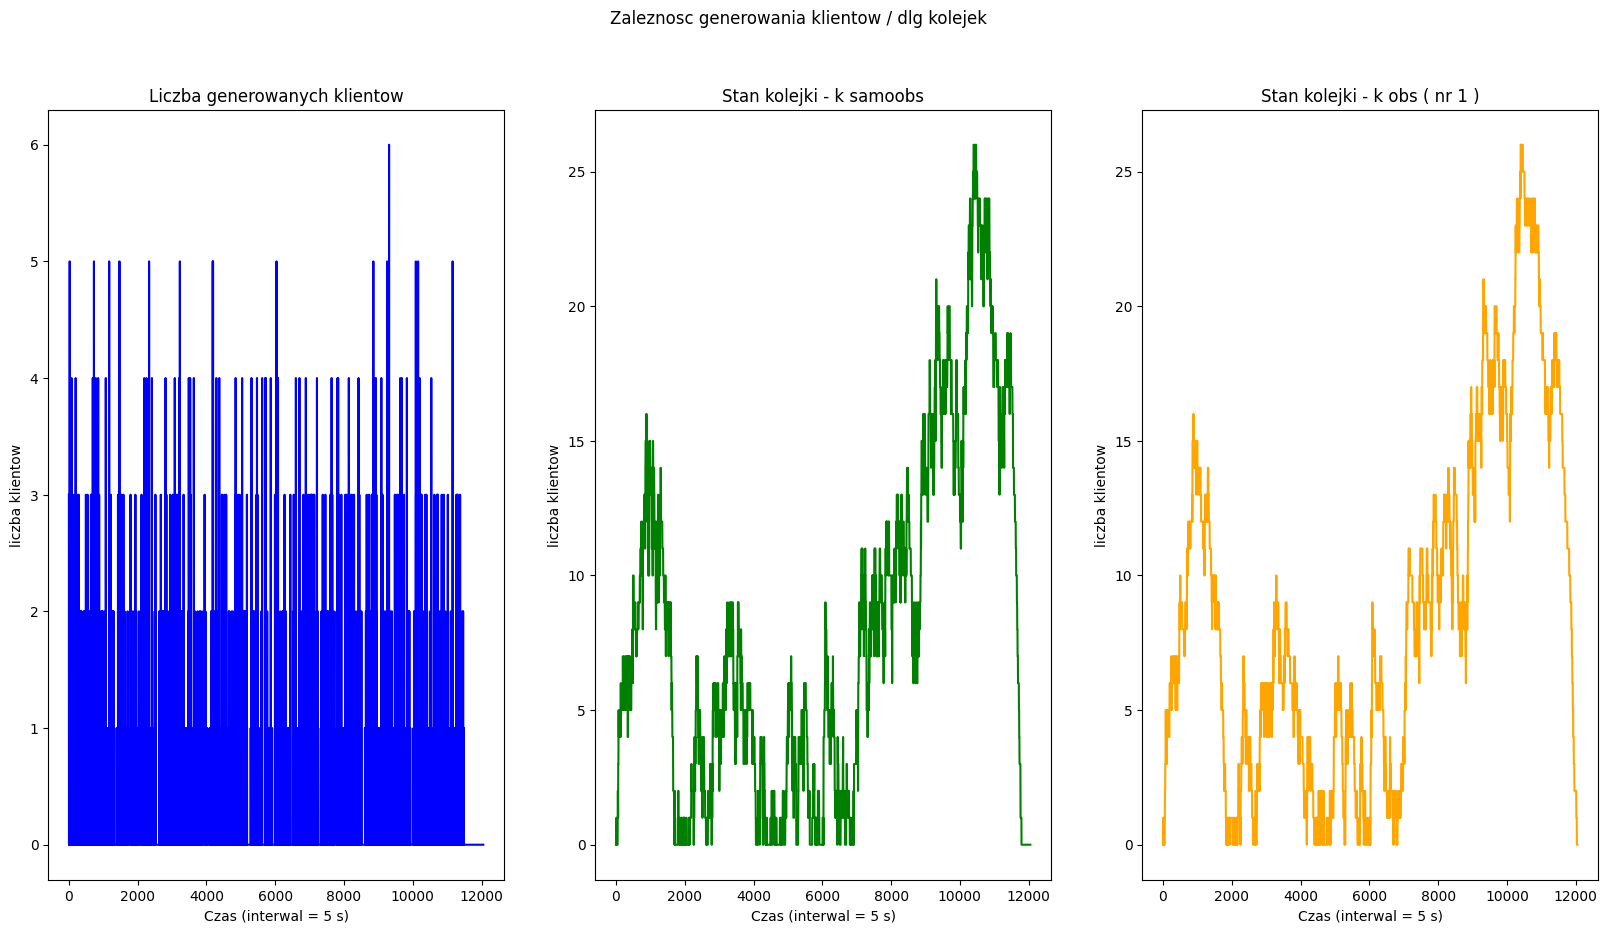



PROBA NR 2
Wszystkie info:
PARAMETRY:
	Czas symulacji: 57600
                            
	Liczba kas samoobslugowych: 3
                            
	Liczba kas obslugowych: 4
                            
	Lambda, amplituda, czestotliwosc: 0.158|0.765|1
-  --  --  --  --  --  --  --  --  --  -
WYNIKI: 
	Realny Czas symulacji: 60293
                          
	Liczba KL obsluzonych w roznych rodzajach (OBS \ SOBS): 1686 \ 683
                          
	Sredni czas obslugi (OBS \ SOBS):  126.3529 \  240.7950
                          
	MAX kolejka (OBS \ SOBS): 18 \ 18
                          
	DELTA czas: 2693
Najdlg Kolejka k_s: 18 w sekundzie: 11518
Klienci liczba: 2369


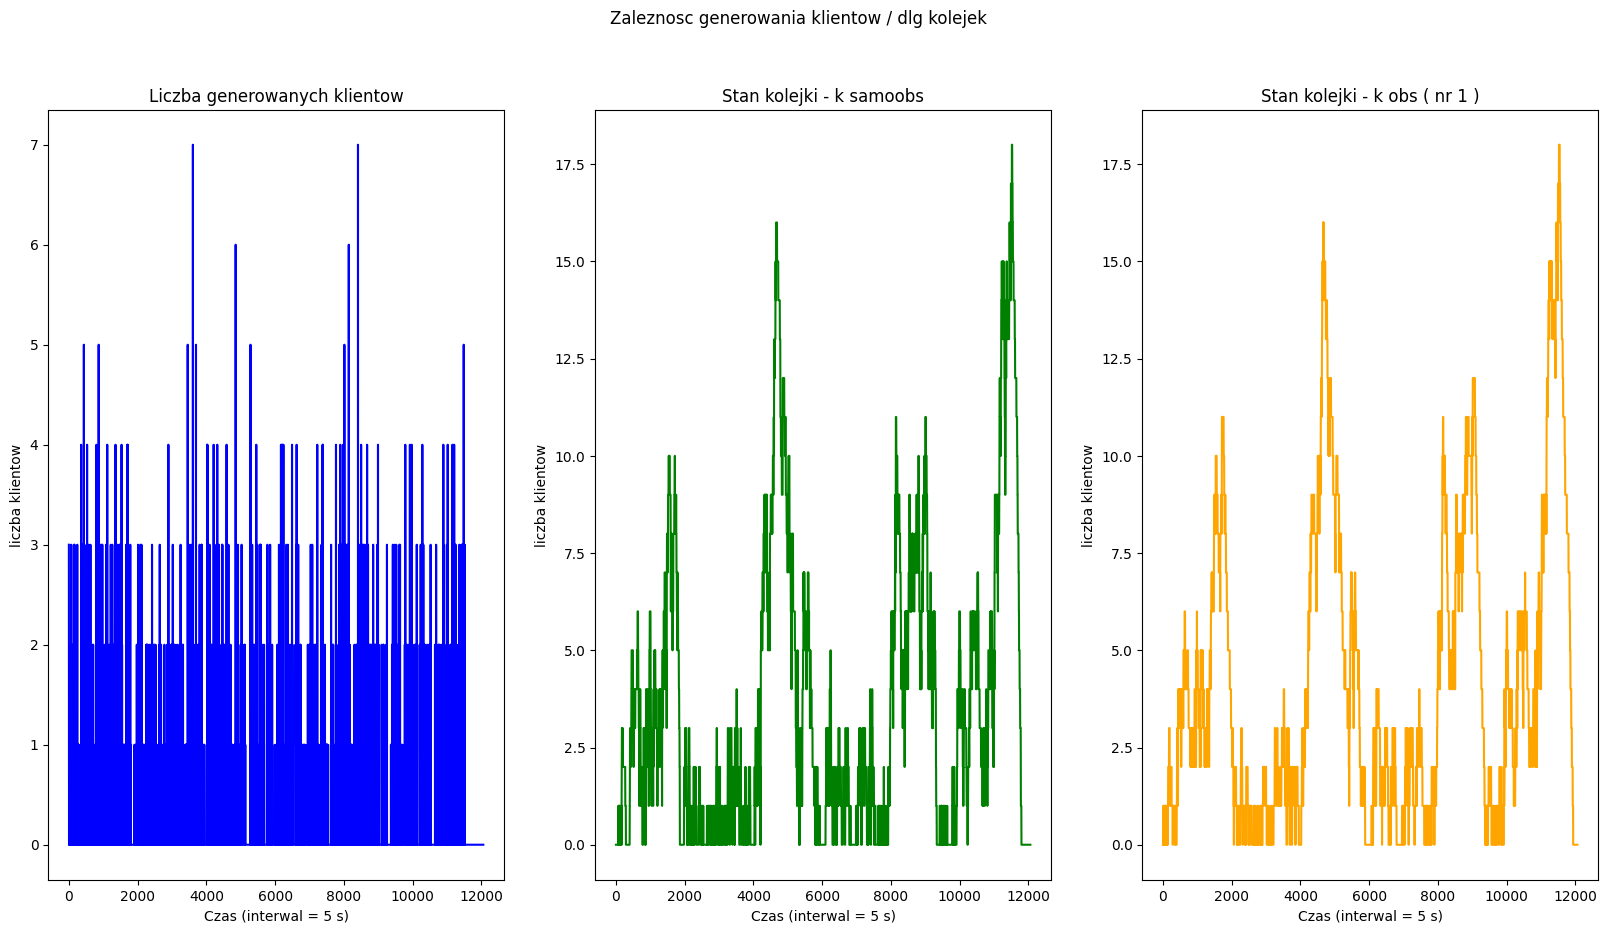



PROBA NR 3
Wszystkie info:
PARAMETRY:
	Czas symulacji: 57600
                            
	Liczba kas samoobslugowych: 3
                            
	Liczba kas obslugowych: 4
                            
	Lambda, amplituda, czestotliwosc: 0.158|0.765|1
-  --  --  --  --  --  --  --  --  --  -
WYNIKI: 
	Realny Czas symulacji: 58818
                          
	Liczba KL obsluzonych w roznych rodzajach (OBS \ SOBS): 1792 \ 709
                          
	Sredni czas obslugi (OBS \ SOBS):  126.0848 \  241.4245
                          
	MAX kolejka (OBS \ SOBS): 21 \ 20
                          
	DELTA czas: 1218
Najdlg Kolejka k_s: 20 w sekundzie: 3818
Klienci liczba: 2501


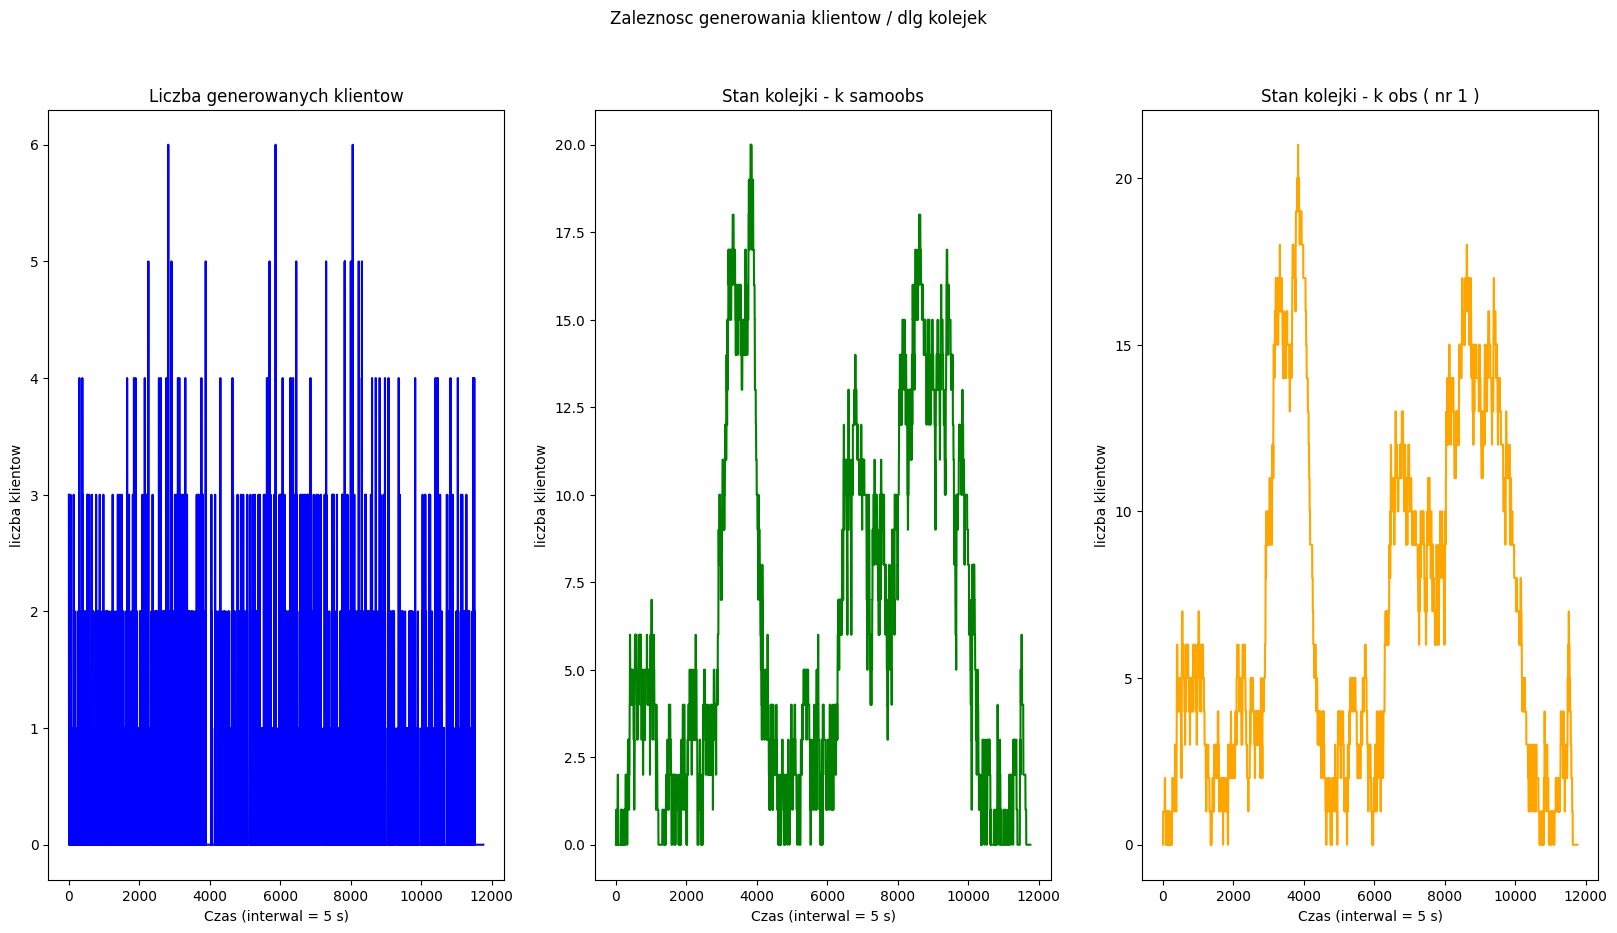



PROBA NR 1
Wszystkie info:
PARAMETRY:
	Czas symulacji: 57600
                            
	Liczba kas samoobslugowych: 8
                            
	Liczba kas obslugowych: 2
                            
	Lambda, amplituda, czestotliwosc: 0.158|0.765|1
-  --  --  --  --  --  --  --  --  --  -
WYNIKI: 
	Realny Czas symulacji: 71256
                          
	Liczba KL obsluzonych w roznych rodzajach (OBS \ SOBS): 1105 \ 1684
                          
	Sredni czas obslugi (OBS \ SOBS):  127.3403 \  239.2197
                          
	MAX kolejka (OBS \ SOBS): 105 \ 37
                          
	DELTA czas: 13656
Najdlg Kolejka k_s: 37 w sekundzie: 9798
Klienci liczba: 2789


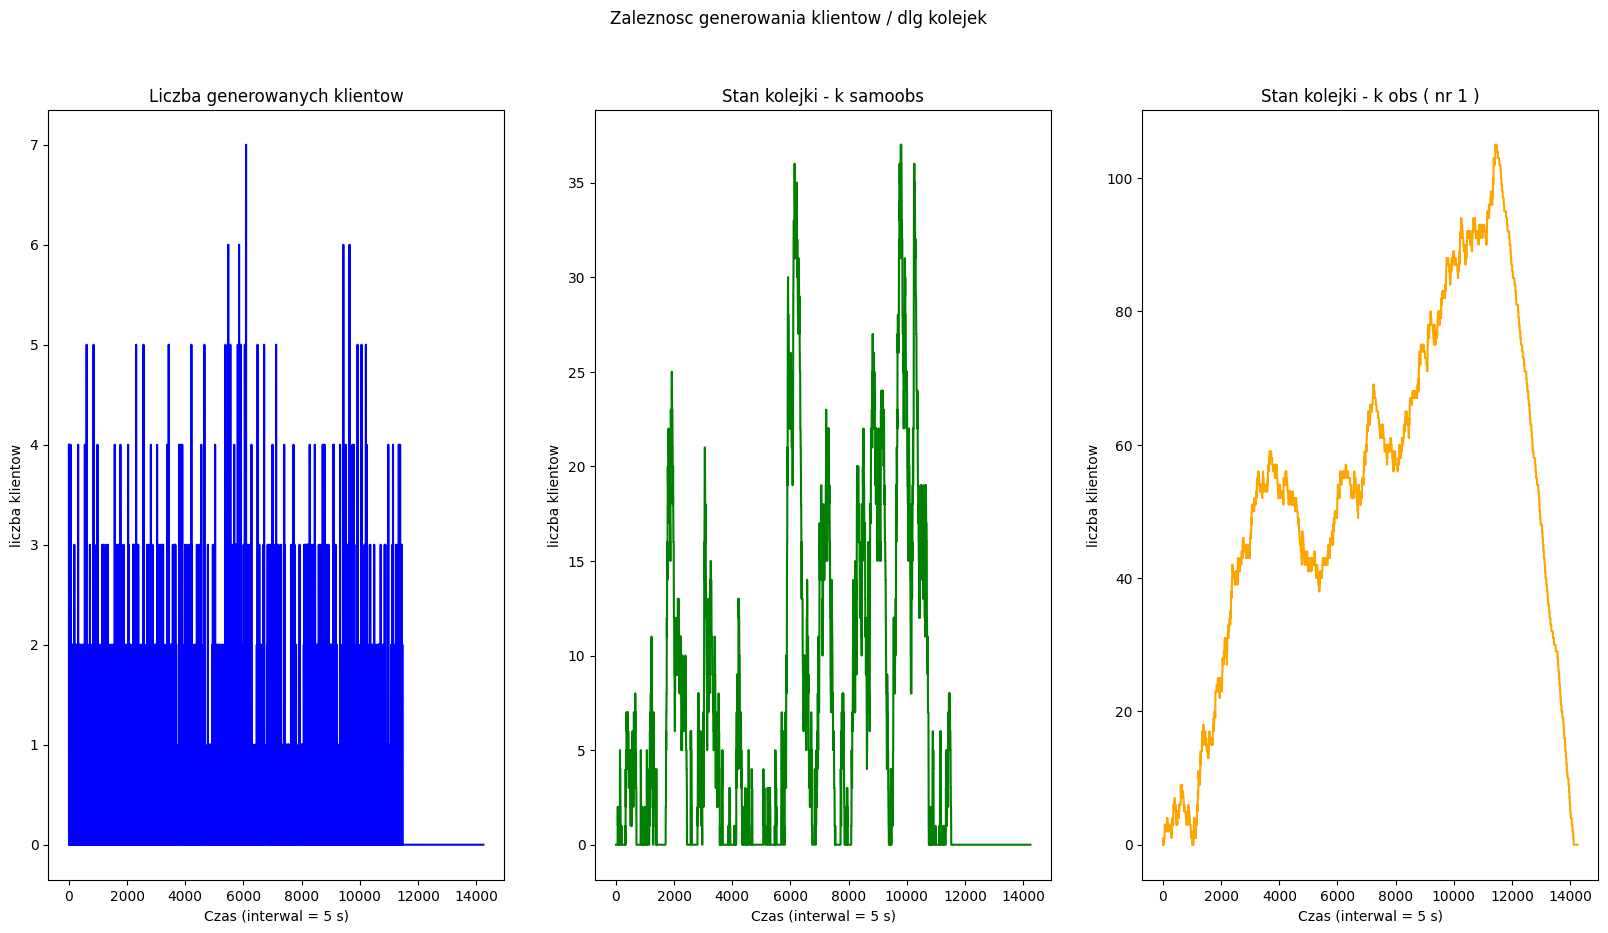



PROBA NR 2
Wszystkie info:
PARAMETRY:
	Czas symulacji: 57600
                            
	Liczba kas samoobslugowych: 8
                            
	Liczba kas obslugowych: 2
                            
	Lambda, amplituda, czestotliwosc: 0.158|0.765|1
-  --  --  --  --  --  --  --  --  --  -
WYNIKI: 
	Realny Czas symulacji: 68612
                          
	Liczba KL obsluzonych w roznych rodzajach (OBS \ SOBS): 1036 \ 1584
                          
	Sredni czas obslugi (OBS \ SOBS):  129.7944 \  241.9274
                          
	MAX kolejka (OBS \ SOBS): 81 \ 38
                          
	DELTA czas: 11012
Najdlg Kolejka k_s: 38 w sekundzie: 10194
Klienci liczba: 2620


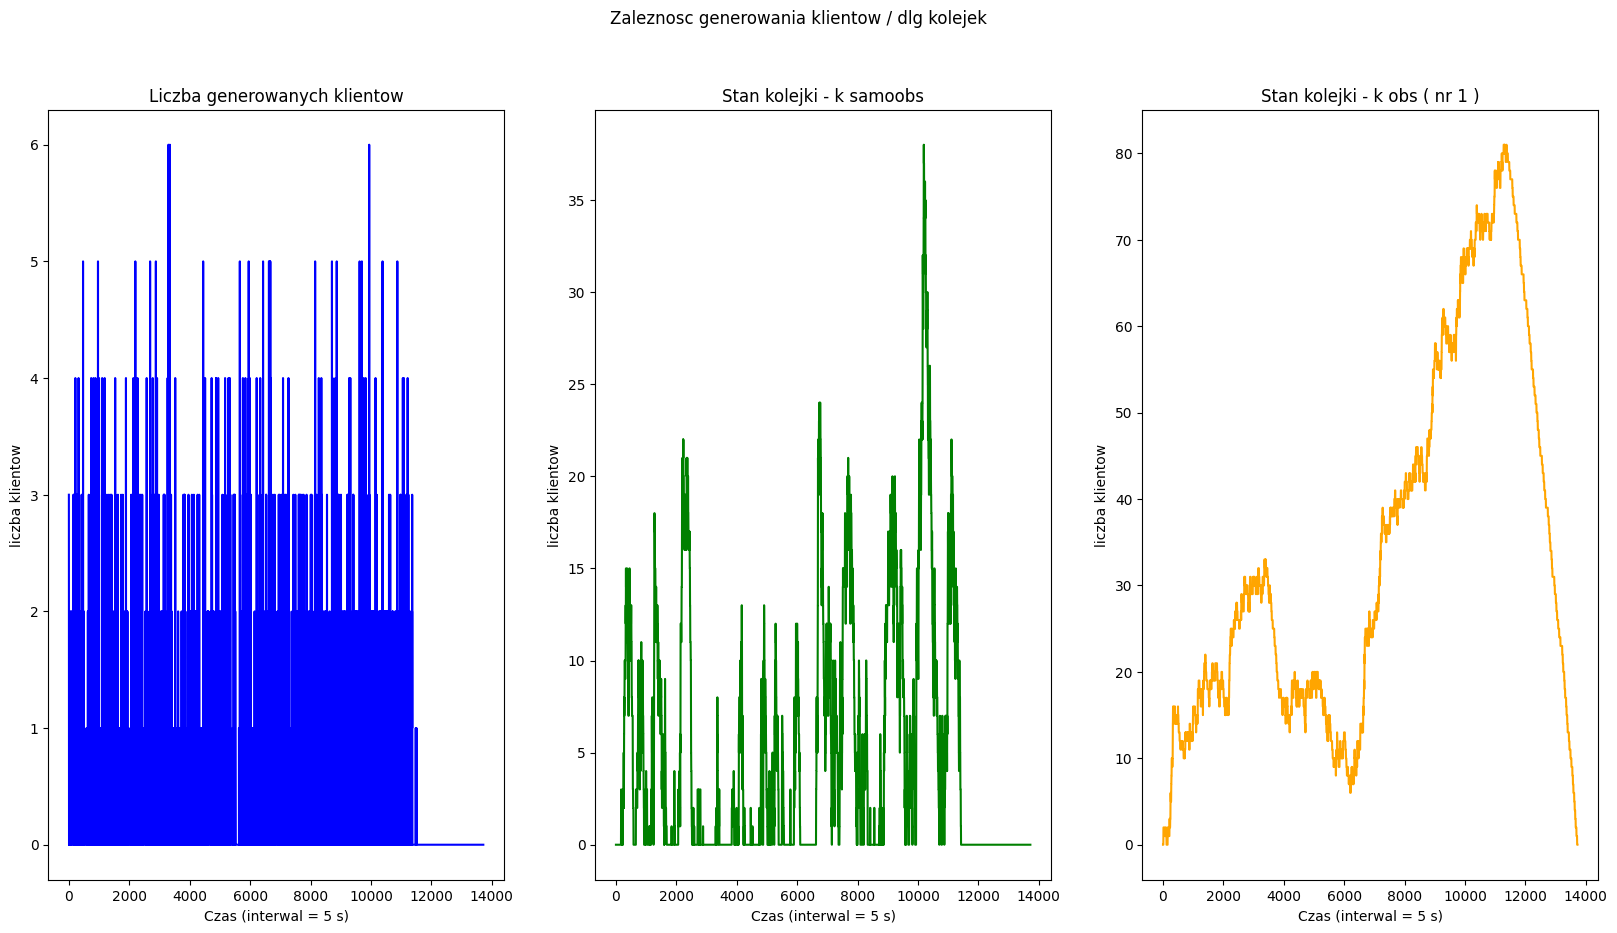



PROBA NR 3
Wszystkie info:
PARAMETRY:
	Czas symulacji: 57600
                            
	Liczba kas samoobslugowych: 8
                            
	Liczba kas obslugowych: 2
                            
	Lambda, amplituda, czestotliwosc: 0.158|0.765|1
-  --  --  --  --  --  --  --  --  --  -
WYNIKI: 
	Realny Czas symulacji: 64878
                          
	Liczba KL obsluzonych w roznych rodzajach (OBS \ SOBS): 967 \ 1401
                          
	Sredni czas obslugi (OBS \ SOBS):  132.2130 \  241.9058
                          
	MAX kolejka (OBS \ SOBS): 71 \ 20
                          
	DELTA czas: 7278
Najdlg Kolejka k_s: 20 w sekundzie: 3634
Klienci liczba: 2368


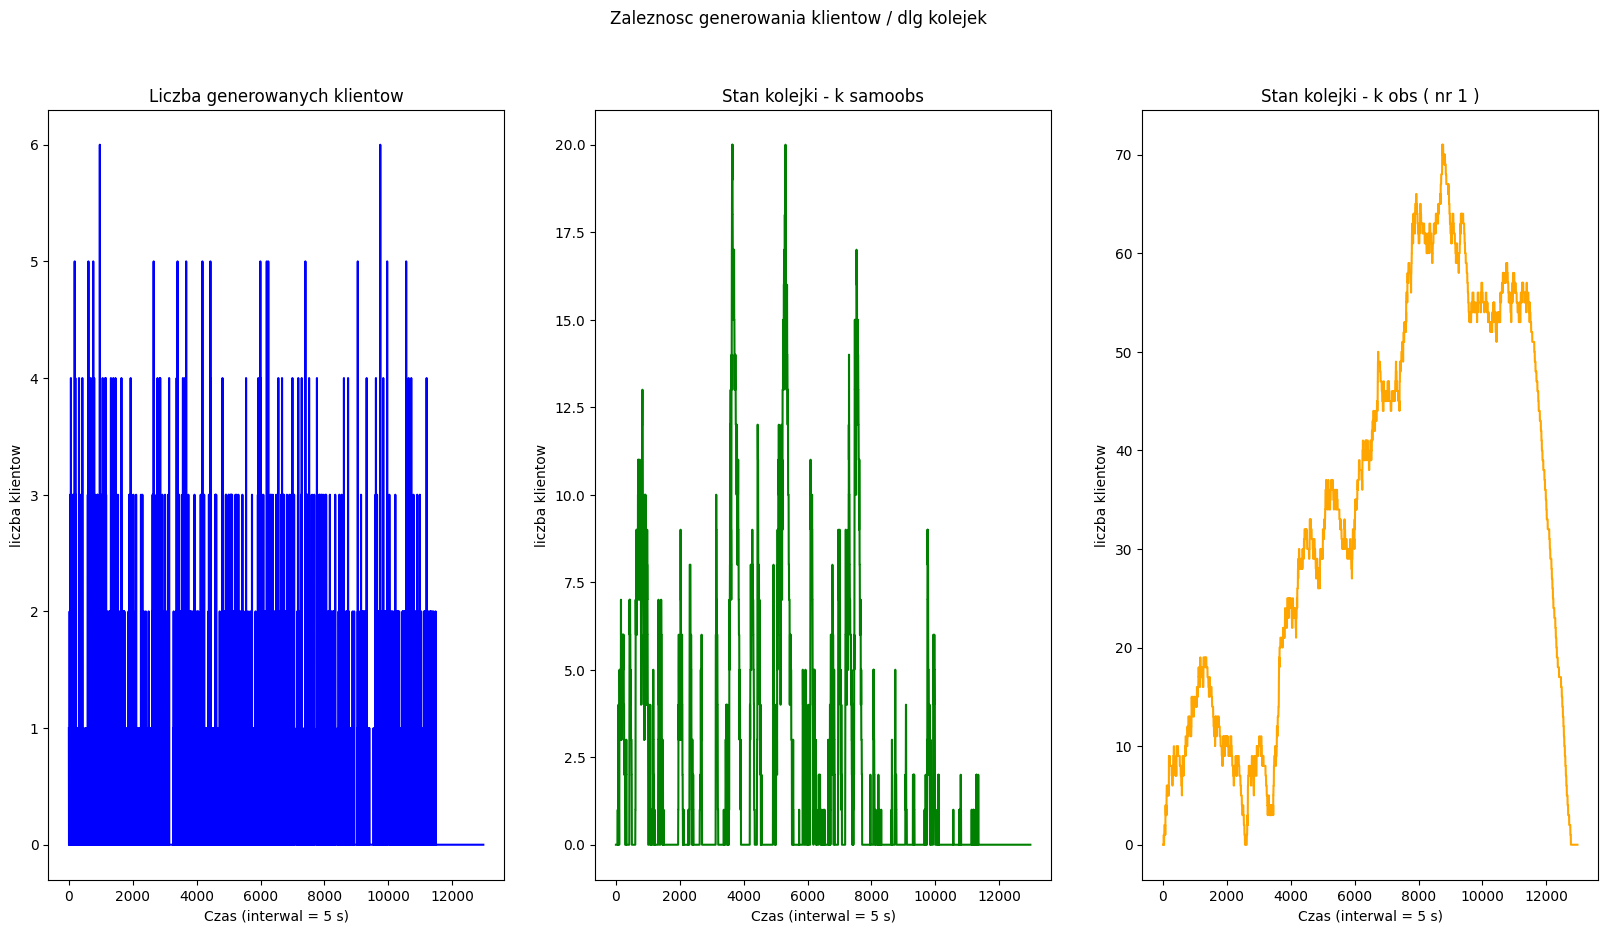



PROBA NR 1
Wszystkie info:
PARAMETRY:
	Czas symulacji: 57600
                            
	Liczba kas samoobslugowych: 8
                            
	Liczba kas obslugowych: 4
                            
	Lambda, amplituda, czestotliwosc: 0.158|0.765|1
-  --  --  --  --  --  --  --  --  --  -
WYNIKI: 
	Realny Czas symulacji: 58054
                          
	Liczba KL obsluzonych w roznych rodzajach (OBS \ SOBS): 1298 \ 1263
                          
	Sredni czas obslugi (OBS \ SOBS):  126.1140 \  238.5701
                          
	MAX kolejka (OBS \ SOBS): 6 \ 5
                          
	DELTA czas: 454
Najdlg Kolejka k_s: 5 w sekundzie: 1921
Klienci liczba: 2561


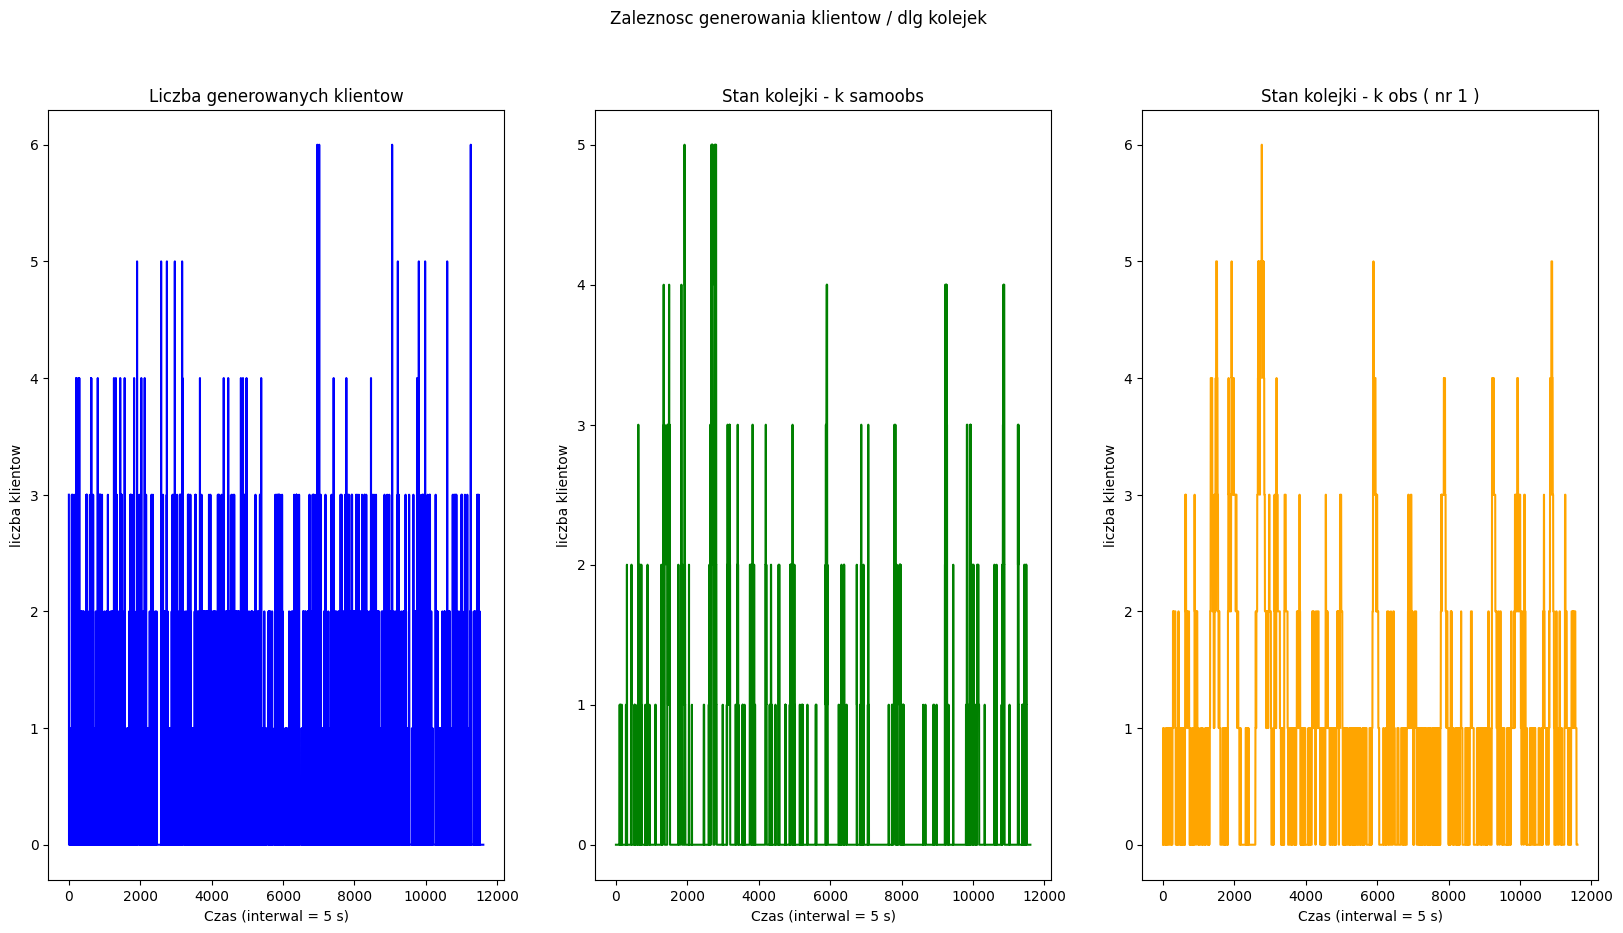



PROBA NR 2
Wszystkie info:
PARAMETRY:
	Czas symulacji: 57600
                            
	Liczba kas samoobslugowych: 8
                            
	Liczba kas obslugowych: 4
                            
	Lambda, amplituda, czestotliwosc: 0.158|0.765|1
-  --  --  --  --  --  --  --  --  --  -
WYNIKI: 
	Realny Czas symulacji: 58158
                          
	Liczba KL obsluzonych w roznych rodzajach (OBS \ SOBS): 1229 \ 1260
                          
	Sredni czas obslugi (OBS \ SOBS):  132.7697 \  232.6294
                          
	MAX kolejka (OBS \ SOBS): 5 \ 5
                          
	DELTA czas: 558
Najdlg Kolejka k_s: 5 w sekundzie: 9997
Klienci liczba: 2489


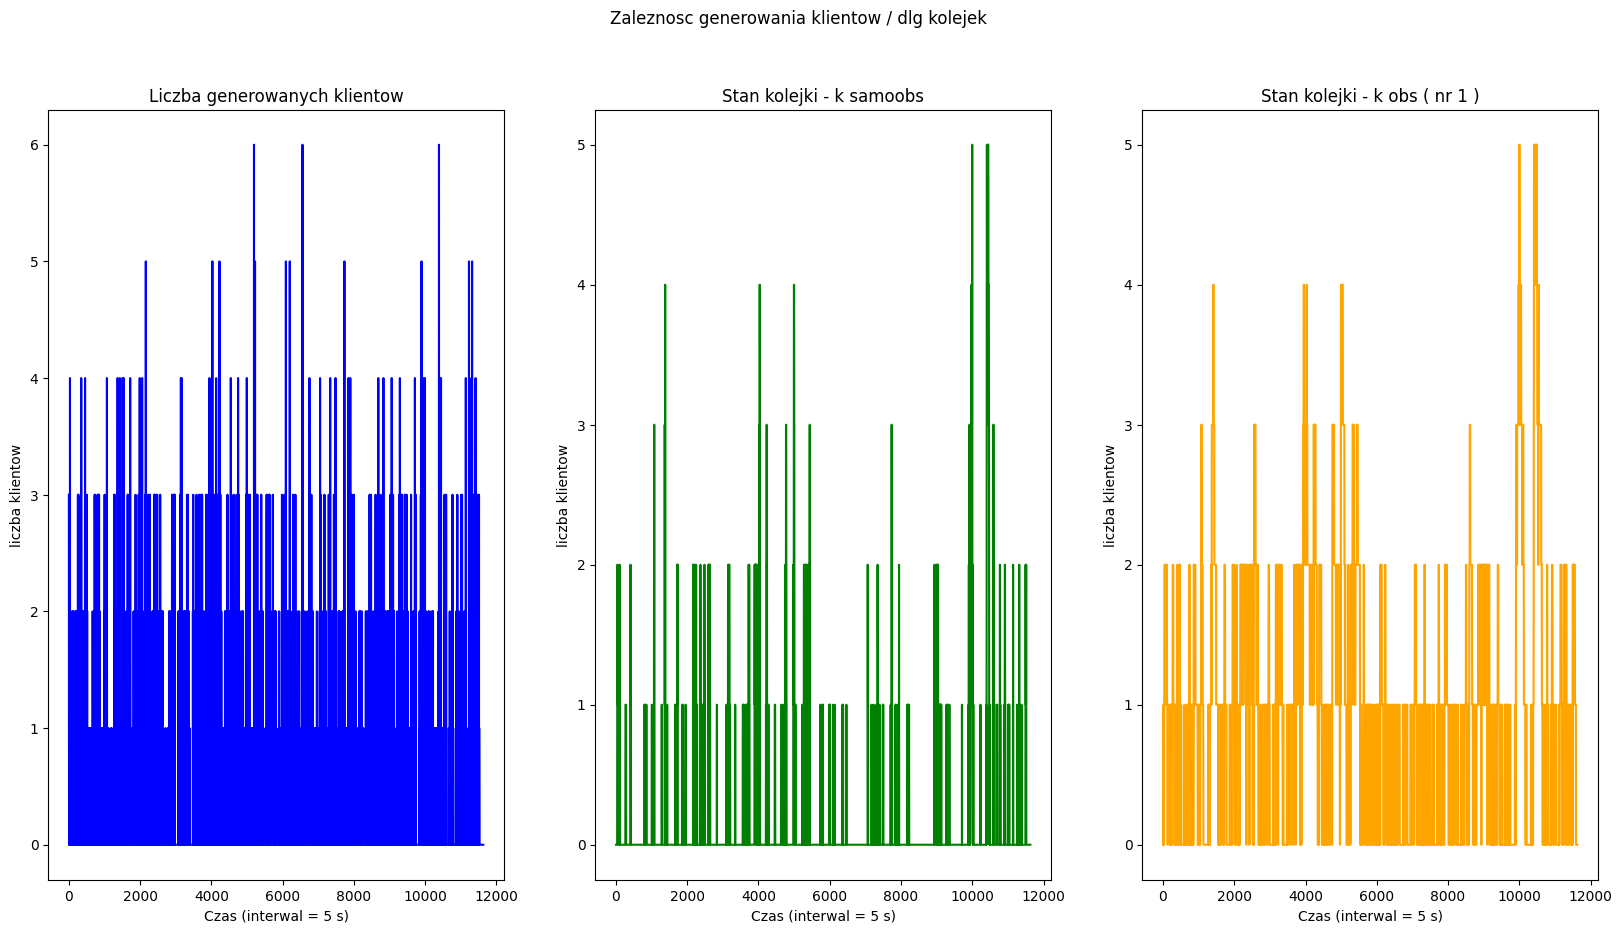



PROBA NR 3
Wszystkie info:
PARAMETRY:
	Czas symulacji: 57600
                            
	Liczba kas samoobslugowych: 8
                            
	Liczba kas obslugowych: 4
                            
	Lambda, amplituda, czestotliwosc: 0.158|0.765|1
-  --  --  --  --  --  --  --  --  --  -
WYNIKI: 
	Realny Czas symulacji: 57960
                          
	Liczba KL obsluzonych w roznych rodzajach (OBS \ SOBS): 1328 \ 1275
                          
	Sredni czas obslugi (OBS \ SOBS):  126.1137 \  240.9898
                          
	MAX kolejka (OBS \ SOBS): 7 \ 7
                          
	DELTA czas: 360
Najdlg Kolejka k_s: 7 w sekundzie: 6764
Klienci liczba: 2603


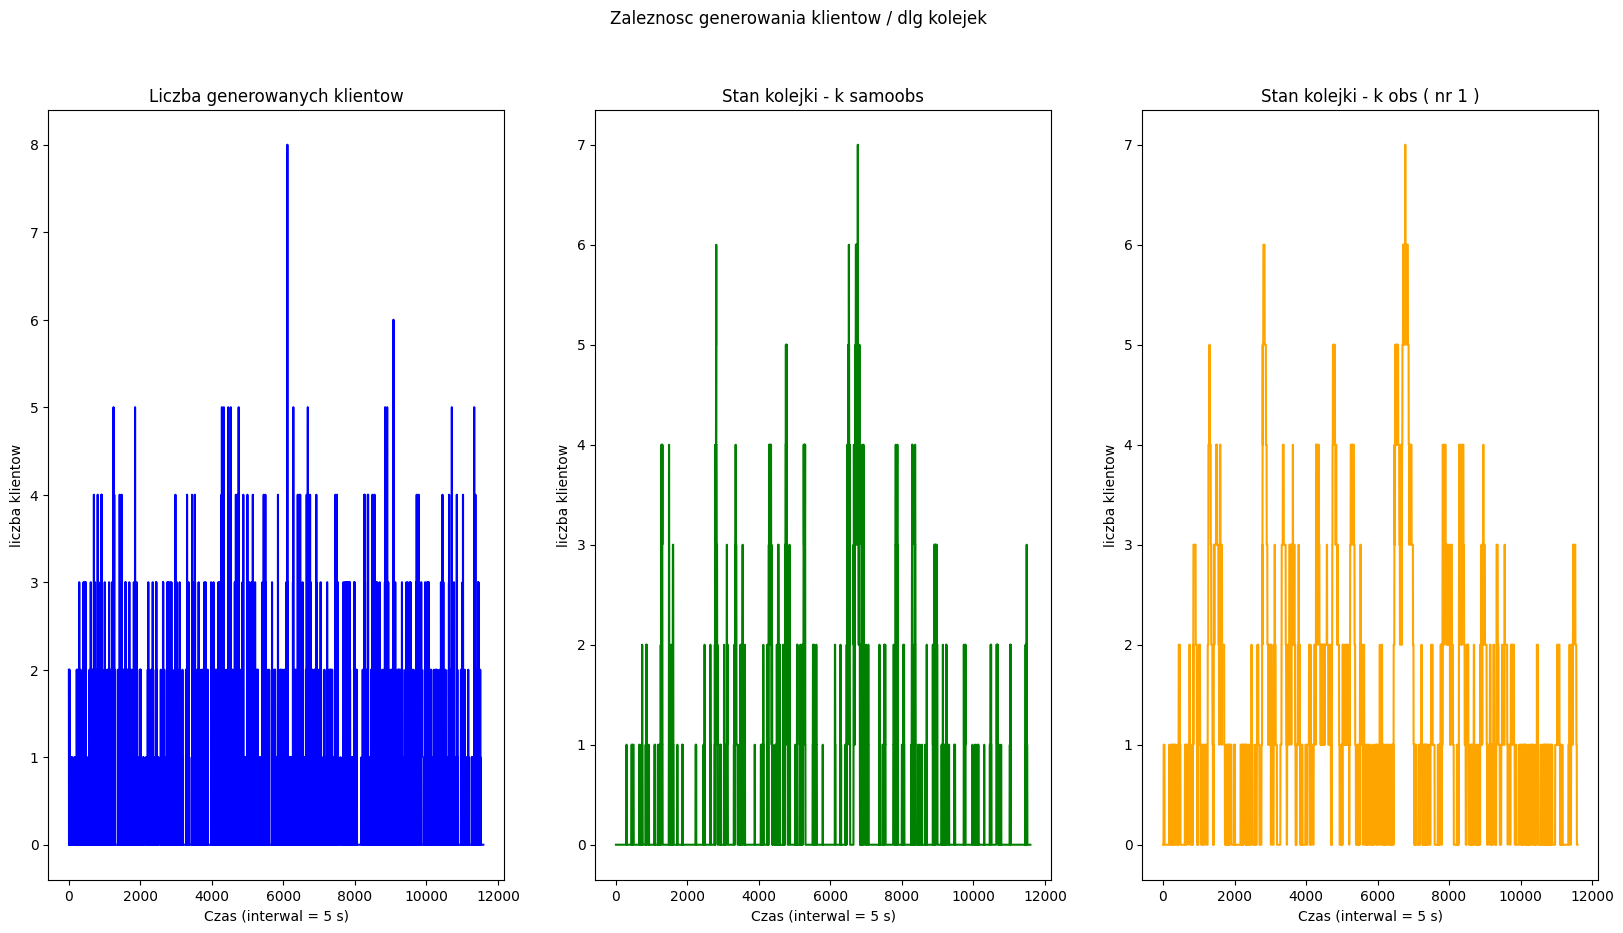

In [80]:
# Przelecimy przez wszystkie symulacje:

# sym_0
for nr_symulacji in range(8):
    for i in range(3):
        print(f"\n\nPROBA NR {i + 1}")
        zapis_sym[nr_symulacji][i].print_opis()
        zapis_sym[nr_symulacji][i].plot_results()
    
print('\n\n\n')

In [81]:
def check_hip_0(sredni_czas_k_s, sredni_czas_k_o):
    def statystyka_testowa_2_srednie(srednia, sd, n1, srednia_h0, sd_h0, n2):

        # Wyznaczam różnicę średnich
        diff_mean = srednia - srednia_h0

        # Wyznaczam odchylenie standardowe różnicy średnich
        pooled_sd = np.sqrt((sd ** 2 / n1) + (sd_h0 ** 2 / n2))

        # Wyznaczam wartość statystyki testowej
        t = diff_mean / pooled_sd

        # Wybieramy test t-Studenta, gdy próbki są małe (n1, n2 <= 30)
        if n1 <= 30 and n2 <= 30:
            test = "t-Studenta"

            # Wyznaczam stopnie swobody
            df = min(n1 - 1, n2 - 1)

            # Wyznaczam p-value i wartość krytyczną
            p_value = 2 * (1 - st.t.cdf(np.abs(t), df=df))

            return [test, t, p_value]
        else:
            # Przeprowadzamy test Z dla dużych prób (n1, n2 > 30)
            test = "Z"

            # Wyznaczam p-value i wartość krytyczną
            p_value = 2 * (1 - st.norm.cdf(np.abs(t)))

            return [test, t, p_value]
    
    # H_0: Sredni czas obslugi klienta jest wiekszy w kasach tradycyjnych
    # MEAN sobs > MEAN obs

        
    def test_hipotezy_0(ciag1, ciag2, alfa=0.05):

        normalnosc = False

        # Sprawdzam normalność testem Shapiro-Wilka
        stat1, p_value_norm1 = st.shapiro(ciag1)
        stat2, p_value_norm2 = st.shapiro(ciag1)

        # Jeśli p > 0.05, dane są z rozkładu normalnego
        if p_value_norm1 > alfa and p_value_norm2 > alfa:
            normalnosc = True

        if normalnosc:
            print("Dane pochodzą z rozkładu normalnego.")

            test, t, p_value = statystyka_testowa_2_srednie(np.mean(ciag1), np.std(ciag1), len(ciag1), np.mean(ciag2), np.std(ciag2), len(ciag2))

            print(f"  Test {test}: t-statystyka = {t:.4f}, p-wartość = {p_value:.4f}")
            if p_value > alfa:
                print("Wniosek: Brak statystycznie istotnej różnicy, średnie czasy obsługi klienta nie różnią się znacząco\n")
            else:
                print("Wniosek: Średnie czasy obsługi klienta są statystycznie różne od siebie. \n")

        else:
            # Dane nie pochodzą z rozkładu normalnego - przeprowadzam test nieparametryczny
            print("Dane nie pochodzą z rozkładu normalnego.")

            mi0 = np.mean(ciag2)

            roznice = [x - mi0 for x in ciag1]
            stat, p_value_wilcoxon = st.wilcoxon(roznice)
            print(f"  Test Wilcoxona: statystyka = {stat:.4f}, p-wartość = {p_value_wilcoxon:.4f}")
            if p_value_wilcoxon > alfa:
                print(f"Wniosek: Brak statystycznie istotnej różnicy między czasami obsługi klienta, "
                    f"mediana dla kas samoobslugowych jest bliska mediany dla kas tradycyjnych.")
            else:
                print(f"Wniosek: Średnie czasy obsługi klienta są statystycznie różne od siebie. "
                    f"Mediana dla kas samoobslugowych jest statystycznie różna od mediany dla kas tradycyjnych ({mi0}).")
    
    
    test_hipotezy_0(sredni_czas_k_o, sredni_czas_k_s)
    
    
def check_hip_1(ilosc_kl_sobs, ilosc_kl_obs):
    # H_1: Ilosc obsluzonych w ciagu dnia klientow jest wieksza w kasach samoobslugowych
    # |Zb_obsl_kl_sobs| > |Zb_obsl_kl_obs|
    def test_hipoteza_1(ilosc_kl_sobs, ilosc_kl_obs):
        if ilosc_kl_sobs > ilosc_kl_obs:
            print('Przyjmujemy hipoteze H_1')
        else:
            print('Odrzucamy hipoteze h_1')
            
    test_hipoteza_1(ilosc_kl_sobs, ilosc_kl_obs)
    
    
    
def check_hip_2(data_1500, data_2500):
        
    
    
    # H_2: Wraz ze wzrostem ruchu w sklepie zwieksza sie dlugosc kolejki
    def test_hipoteza2(data_1500, data_2500, alpha=0.05):
        """
        Testuje hipotezę, że maksymalna długość kolejki rośnie wraz ze wzrostem liczby klientów
        za pomocą testu U Manna-Whitneya.

        :param data_1500: Lista lub tablica wartości długości kolejki dla 1500 klientów.
        :param data_2500: Lista lub tablica wartości długości kolejki dla 2500 klientów.
        :param alpha: Poziom istotności testu (domyślnie 0.05).
        :return: Statystyka testu i wartość p
        """
        stat, p_value = st.mannwhitneyu(data_2500, data_1500, alternative='greater')

        print(f"Statystyka testowa: {stat:.4f}")
        print(f"Wartość p: {p_value:.4f}")

        if p_value < alpha:
            print("Odrzucamy hipotezę zerową: Długość kolejki rośnie wraz z liczbą klientów.")
        else:
            print(
                "Brak podstaw do odrzucenia hipotezy zerowej: Nie mamy wystarczających dowodów na wzrost długości kolejki.")

        return stat, p_value
        
    test_hipoteza2(data_1500, data_2500)


In [82]:
# H0:
# War1 = sym_1_0
# War2 = sym_2_0

war_1: SymulacjaOpis= zapis_sym[1][0]
war_2: SymulacjaOpis = zapis_sym[2][0]

war_1_wincej: SymulacjaOpis = zapis_sym[5][0]
war_2_wincej: SymulacjaOpis = zapis_sym[6][0]

print("\nH_0")
print('WARIANT 1')
check_hip_0(war_1.ALL_czas_obsl_kl__k_0, war_1.ALL_czas_obsl_kl__k_s)
print(f'srednia war 1 {war_1.MEAN_czas_obsl_kl__k_s}')
print(f'srednia war 1 {war_1.MEAN_czas_obsl_kl__k_o}')

print('WARIANT 2')
check_hip_0(war_2.ALL_czas_obsl_kl__k_0, war_2.ALL_czas_obsl_kl__k_s)
print(f'srednia war 2 {war_2.MEAN_czas_obsl_kl__k_s}')
print(f'srednia war 2 {war_2.MEAN_czas_obsl_kl__k_o}')


print("\nH_1")
print('WARIANT 1')
check_hip_1(war_1.num_klient__k_s, war_1.num_klient__k_o)
print(f'max war 1 { war_1.num_klient__k_s}')
print(f'max war 1 { war_1.num_klient__k_o}')

print('WARIANT 2')
check_hip_1(war_2.num_klient__k_s, war_2.num_klient__k_o)
print(f'max war 2 { war_2.num_klient__k_s}')
print(f'max war 2 { war_2.num_klient__k_o}')

print("\nH_2")
print('WARIANT 1')
check_hip_2(war_1.MAX_dlg_kolej__k_s, war_1_wincej.MAX_dlg_kolej__k_s)
print(war_1.MAX_dlg_kolej__k_s)
print(war_1_wincej.MAX_dlg_kolej__k_s)
print('WARIANT 2')
check_hip_2(war_2.MAX_dlg_kolej__k_s, war_2_wincej.MAX_dlg_kolej__k_s)
print(war_2.MAX_dlg_kolej__k_s)
print(war_2_wincej.MAX_dlg_kolej__k_s)


H_0
WARIANT 1
Dane nie pochodzą z rozkładu normalnego.
  Test Wilcoxona: statystyka = 21372.0000, p-wartość = 0.0000
Wniosek: Średnie czasy obsługi klienta są statystycznie różne od siebie. Mediana dla kas samoobslugowych jest statystycznie różna od mediany dla kas tradycyjnych (128.11444141689373).
srednia war 1 234.1244635193133
srednia war 1 128.11444141689373
WARIANT 2
Dane nie pochodzą z rozkładu normalnego.
  Test Wilcoxona: statystyka = 55974.0000, p-wartość = 0.0000
Wniosek: Średnie czasy obsługi klienta są statystycznie różne od siebie. Mediana dla kas samoobslugowych jest statystycznie różna od mediany dla kas tradycyjnych (126.96527777777777).
srednia war 2 234.8131188118812
srednia war 2 126.96527777777777

H_1
WARIANT 1
Odrzucamy hipoteze h_1
max war 1 466
max war 1 734
WARIANT 2
Przyjmujemy hipoteze H_1
max war 2 808
max war 2 576

H_2
WARIANT 1
Statystyka testowa: 1.0000
Wartość p: 0.5000
Brak podstaw do odrzucenia hipotezy zerowej: Nie mamy wystarczających dowodów na w